## Load all the libraries required

In [1]:
# Import libraries
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Loading the data from the private date source

In [2]:
df = pd.read_csv("Data/loan.csv",low_memory=False)

## Check for Duplicates

In [3]:
print("# Duplicate ids: ", df[df.duplicated('id')].shape[0])
print("# Duplicate member ids: ", df[df.duplicated('member_id')].shape[0])

# Duplicate ids:  0
# Duplicate member ids:  0


## Deleting unnecessary columns

In [4]:
# there are no duplicates so drop the id columns
# also drop the URL column as the values only differ by the id
df.drop(['id','member_id','url'],axis=1,inplace=True)

# drop all the columns containing either all NA or a constant value
for col in df:
    if len(df[col].value_counts()) < 2:
        df.drop([col],axis=1,inplace=True)

# grade is replicated in subgrade so drop
df.drop(['grade'],axis=1,inplace=True)

# Most last payment dates are after loan issue date
# drop field as not always available when funding
print(len(df[df['last_pymnt_d'] >= df['issue_d']]), ' of ', len(df), 'last payment dates after loan issue date')
df.drop(['last_pymnt_d'],axis=1,inplace=True) 

# also drop 'last_pymnt_amnt' as it's linked to this field
df.drop(['last_pymnt_amnt'],axis=1,inplace=True) 

# drop all fields that include data gathered after funding
df.drop(['total_pymnt', 'total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee'],axis=1,inplace=True)

# 'funded_amnt_inv','loan_amnt', and 'funded_amnt'are all very similar values 
# 'funded_amt_inv' is of no use as it only tells us how popular it was with investors
# The differrence between the loan amount and funded amount may be useful 
# e.g. If the loan is not fully funded it may increase the change of default in debt consolidation scenarios

# calculate the % funded before we drop the fields
df['pct_funded'] = df['funded_amnt']/df['loan_amnt']
df.drop(['funded_amnt_inv', 'funded_amnt'],axis=1,inplace=True)

# I'm not planning on conducting any free text analysis
# drop free text columns
df.drop(['emp_title','title','desc'],axis=1,inplace=True) 

# The first 3 digits of a zip code can be used to identify a state (or group of states)
# and a sub-region.  While state data is easy fo find, i can find no reliable source of
# sub-region. As the state is available in the addr state field, I'll drop the zip code
df.drop(['zip_code'],axis=1,inplace=True) 


22504  of  39717 last payment dates after loan issue date


## Deleting unnecessary rows

In [5]:
# As we are interested in loans that have been completed (either repaid or charged off)
# We can remove all loans that are still current
df= df[~(df['loan_status'] == 'Current')]

# Drop columns that are now either blank or contain a single value
# after removing loans with current status
df.drop(['next_pymnt_d','out_prncp','out_prncp_inv'],axis=1,inplace=True) 

# drop purpose categories with low numbers of loans as
# the insight for these purposes will be unreliable
small_volume_purpose = df['purpose'].value_counts() > 500
small_volume_purpose = small_volume_purpose[small_volume_purpose] 
df = df[df['purpose'].isin(small_volume_purpose.index)]

## Fixing column  formats

In [6]:
# Convert percentage strings to float
df['int_rate'] = df['int_rate'].str.replace('%','').astype('float')
df['revol_util'] = df['revol_util'].str.replace('%','').astype('float')

# convert the term strings to int
df['term'] = df.term.str[1:3].astype('Int32')

# convert the emp_length column to int
df['emp_length'].fillna('0',inplace=True)
df['emp_length'].replace('< 1 year', '0', inplace=True)
df['emp_length']=df['emp_length'].str.replace('+ years','',regex=False)
df['emp_length']=df['emp_length'].str.replace(' years','')
df['emp_length']=df['emp_length'].str.replace(' year','')
df['emp_length']=df['emp_length'].astype('int')


In [7]:
# convert date fields
for col in ['issue_d','earliest_cr_line','last_credit_pull_d']:
    df[col] = pd.to_datetime(df[col], format='%b-%y')
    # add new date related calculated fields
    df[col+'_year'] = df[col].dt.year
    df[col+'_month'] = df[col].dt.month
    df[col+'_quarter'] = df[col].dt.quarter

# 2007 does not look like a full year so delete
print(df[df['issue_d_year']==2007].issue_d_month.value_counts())
df = df[df['issue_d_year']>2007] 

12    84
10    44
11    32
8     30
7     26
9     18
6      1
Name: issue_d_month, dtype: int64


## Handle null values

In [8]:
def null_pct(df):
    nulls = pd.DataFrame(round((df.isnull().sum()/len(df.index)*100),4),columns=['pct_null'])
    nulls = nulls[nulls['pct_null'] > 0]
    print(nulls.sort_values(['pct_null'],ascending=False))

null_pct(df)

                            pct_null
mths_since_last_record       93.5141
mths_since_last_delinq       65.0526
pub_rec_bankruptcies          1.1837
revol_util                    0.1237
last_credit_pull_d            0.0027
last_credit_pull_d_year       0.0027
last_credit_pull_d_month      0.0027
last_credit_pull_d_quarter    0.0027


In [9]:
# Some members have a revolving credit balance of 0 
# but a revolving credit utilisation rate > 0 

df_copy = df.copy()
mask = (df_copy['revol_bal']==0) & ~(df_copy['revol_util']==0)

print( len(df[mask]), " records with incorrect revol_util value")

# In this instance set the revol_util to 0
df.loc[mask, 'revol_util'] = 0

# confirm the values have been set
df_copy = df.copy()
mask = (df_copy['revol_bal']==0) & ~(df_copy['revol_util']==0)

print( len(df[mask]), " records with incorrect revol_util value")

121  records with incorrect revol_util value
0  records with incorrect revol_util value


In [10]:
# Fix rows with blank revol_util but non-zero revol_bal
# Lets set that one row to the median

df_copy = df.copy()
mask = (df_copy['revol_bal']>0) & (pd.isna(df_copy['revol_util']))
mask2 = (df_copy['revol_bal']>0) & ~(pd.isna(df_copy['revol_util']))
df.loc[mask, 'revol_util'] = df[mask2].revol_util.median()

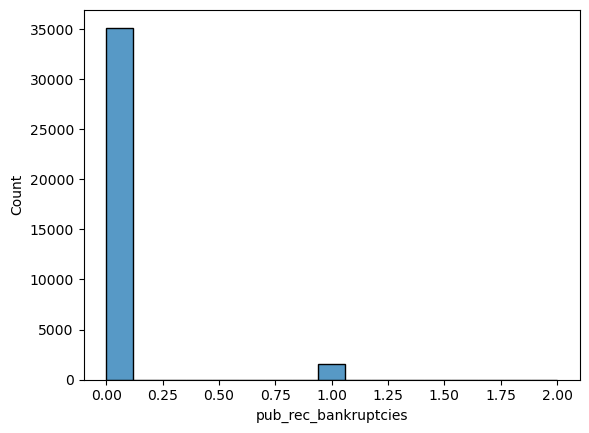

In [11]:
# Lets look at pub_rec_bankruptcies
ax = sns.histplot(df['pub_rec_bankruptcies'])
plt.plot()    

# setting missing values to zero with have the 
# least impact on the distribution
df_copy = df.copy()
mask = pd.isna(df_copy['pub_rec_bankruptcies'])
df.loc[mask, 'pub_rec_bankruptcies'] = 0

In [12]:
# lets look at the last credit pull field
df_copy = df.copy()
mask = pd.isna(df_copy['last_credit_pull_d'])
print(df.loc[mask,'last_credit_pull_d'])

# There is only 1 row with last_credit_pull_d not set
# Drop the row
df.drop(26025,axis=0, inplace=True)

26025   NaT
Name: last_credit_pull_d, dtype: datetime64[ns]


In [13]:
# check remaining null values
null_pct(df)

                        pct_null
mths_since_last_record   93.5139
mths_since_last_delinq   65.0517


### These fields containing null values are ok because
### there is a valid reason for them to be null if there 
### has not been any previous record/delinquency
###
### These will need to be evaluated with the nulls removed

## Add calculated metrics from 3rd party datasets

### added geographical data based on state and a column to indicate if a loan has defaulted

### data sources used:

- IRS ["Standard Postal Service State Abbreviations and ZIP Codes"](https://www.irs.gov/pub/irs-pdf/p5594.pdf) (accessed Wednesday, February 1, 2023)
- US Census ["US Regional Divisions"](https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf) (accessed Wednesday, February 1, 2023)

In [14]:
# load states lookup and confirm all states used are in the lookup
states = pd.read_csv("Data/State_Data.csv",low_memory=False)
states.set_index('Abbr.', inplace=True)

# check all states in the data are in the lookup dataframe
print(len(df[~df['addr_state'].isin(states.index)]) , " States not found")

0  States not found


In [15]:
# populate new geographical fields
df['state'] = df.addr_state.apply(lambda x:states.at[x,'State'])
df['region'] = df.addr_state.apply(lambda x:states.at[x,'Region'])
df['division'] = df.addr_state.apply(lambda x:states.at[x,'Division'])

# drop the original addr_state field
df.drop('addr_state', axis=1, inplace=True)

# drop states with low numbers of loans as
# the insight for these states will be unreliable

#exclude low volume states
small_volume_states = df['state'].value_counts() > 200
small_volume_states = small_volume_states[small_volume_states] 

df = df[df['state'].isin(small_volume_states.index)]

In [16]:
# calculate a target column
df['defaulted'] = df.apply(lambda x: True if x['loan_status'] == 'Charged Off' else False, axis= 1)




# Univariate analysis
### Look at the continuous columns to try and understand
### their distribution and spot potential issues/patterns

In [17]:
# lets look at the continuous columns in detail

def univariate_continuous_plots(col):
    """ Show visualisations for continuous data
        these include
           - metadata (data type and unique values)
           - statistics (count, max etc.)
           - Boxplot showing distribution of loans
           - histogram showing distribution of loans
    """
    # define the vallue to use for the number of bins
    count = len(df[col].unique())
    if (count > 35):
         count = 35

    # set the style     
    plt.style.use('bmh')

    # set up the plot layout
    fig = plt.figure(figsize=(10,4.3))
    ax1 = plt.subplot2grid((2,3), (0,0))                # topleft
    ax2 = plt.subplot2grid((2,3), (0,1), colspan=2)     # right
    ax3 = plt.subplot2grid((2,3), (1,0))                # bottom left
    ax4 = plt.subplot2grid((2,3), (1,1), colspan=2)     # bottom right

    # Metadata
    ax1.text(0.5, 0.70, 'Column Name:   ' + col, transform=ax1.transAxes, fontsize=15,horizontalalignment='center',verticalalignment='center')
    ax1.text(0.5, 0.50, 'Data Type:   ' + str(df[col].dtype) , transform=ax1.transAxes, fontsize=15,horizontalalignment='center',verticalalignment='center')
    ax1.text(0.5, 0.30, '#Unique Values:  ' + str(len(df[col].unique())) , transform=ax1.transAxes, fontsize=15,horizontalalignment='center',verticalalignment='center')
    ax1.axis('off')
    ax1.axis('tight')

    # box plot
    sns.boxplot(data=df, x=col, ax=ax2)
    ax2.set_title('Distribution of ' + col + ' for all loans')

    # stats
    desc = pd.DataFrame(df[col].describe())
    desc[col] = round(desc[col])
    table = ax3.table(cellText=desc.values, colLabels=desc.columns, rowLabels=desc.index, loc='center',cellLoc='center' )
    ax3.axis('off')
    ax3.axis('tight')

    # histogram
    sns.histplot(data=df, x=col, bins=count, ax=ax4)
    # ax4.sharex(ax2)  -- didn't work revisit if have time
    fig.tight_layout()
    
    plt.show() 


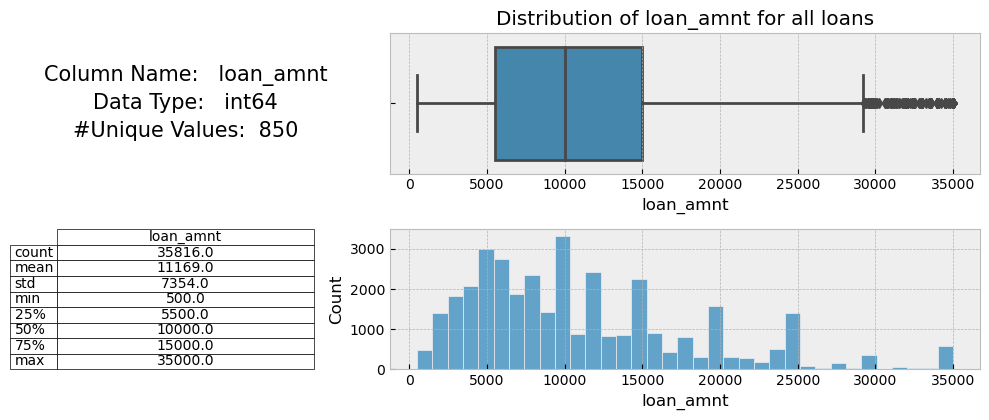

d:\Repos\Lending-Club-Case-Study\LendingClubEnv\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
d:\Repos\Lending-Club-Case-Study\LendingClubEnv\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


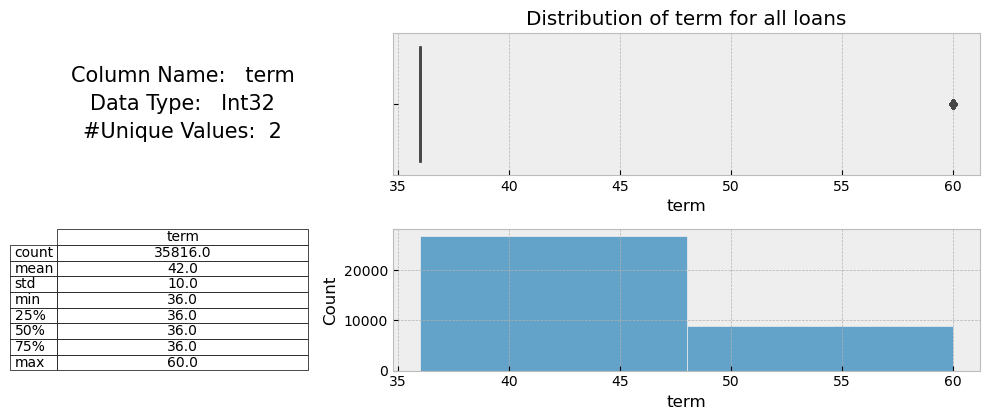

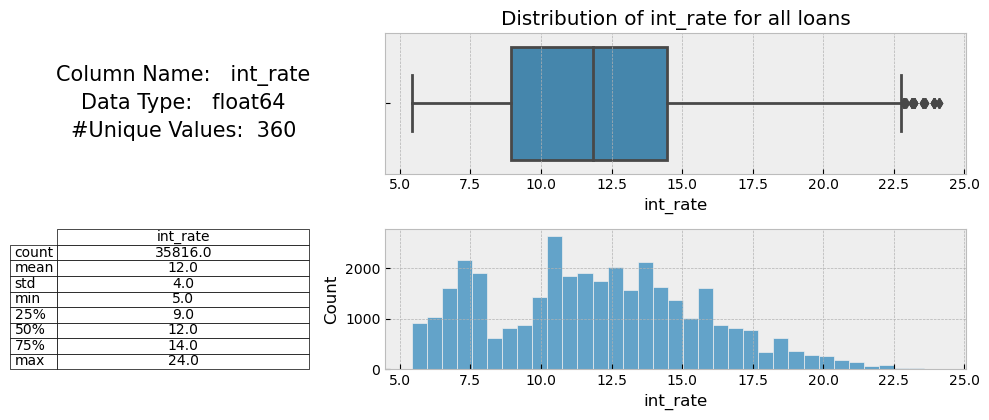

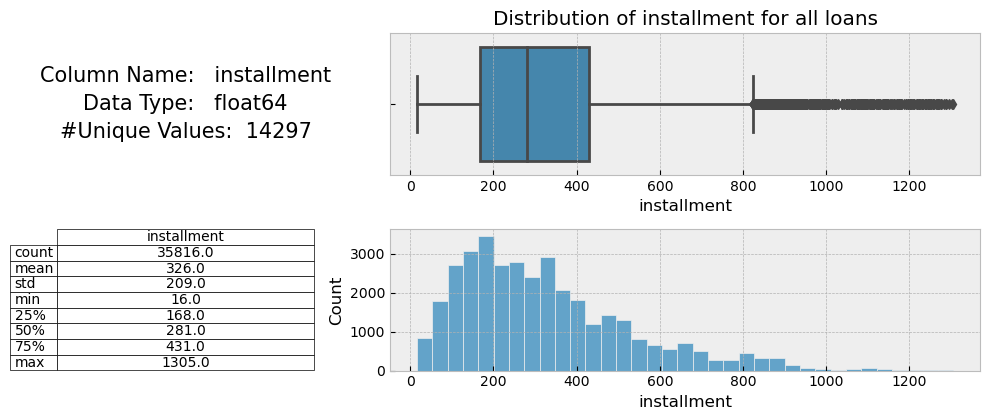

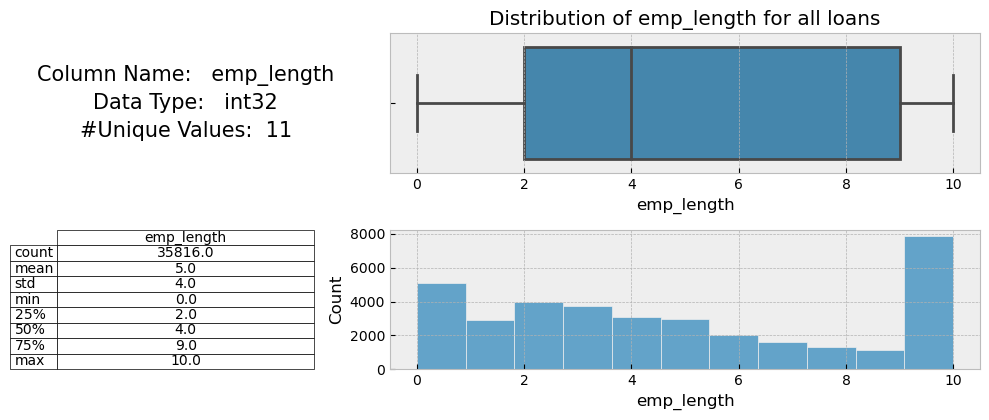

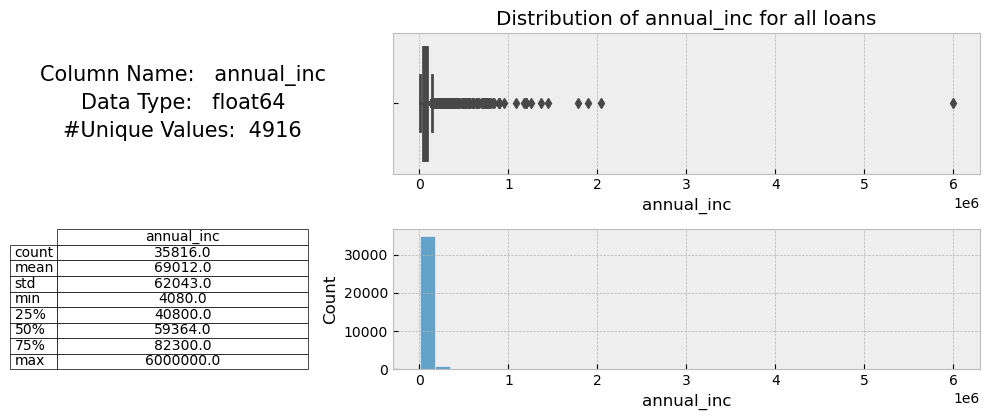

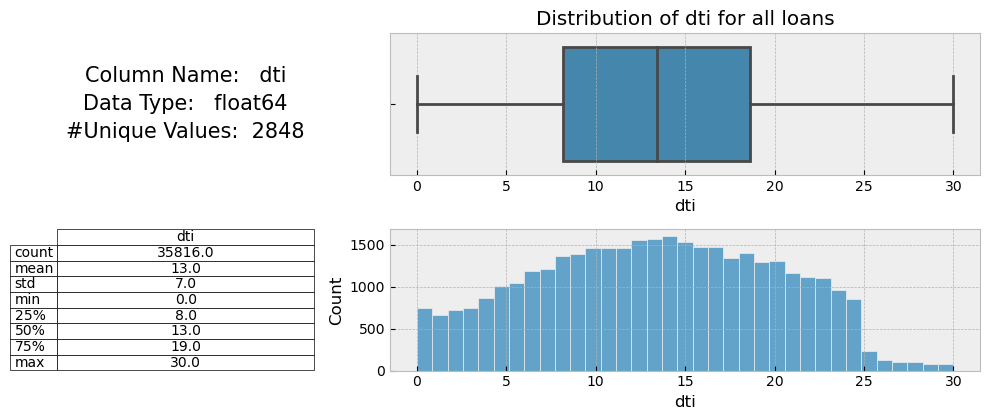

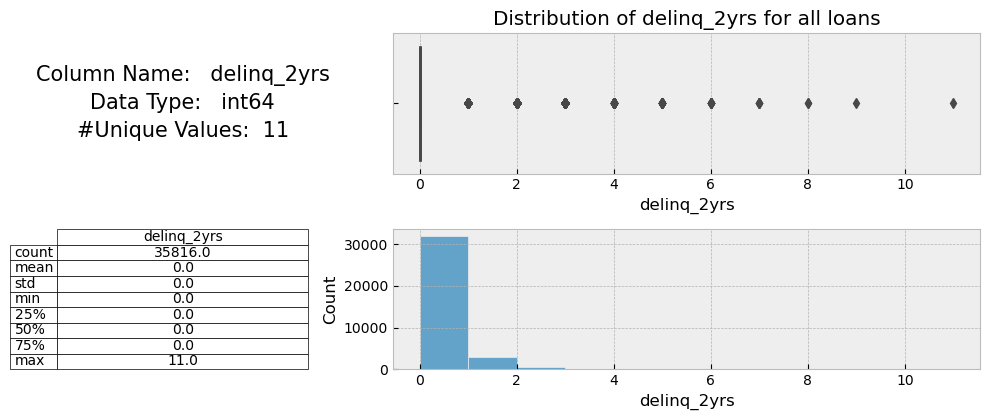

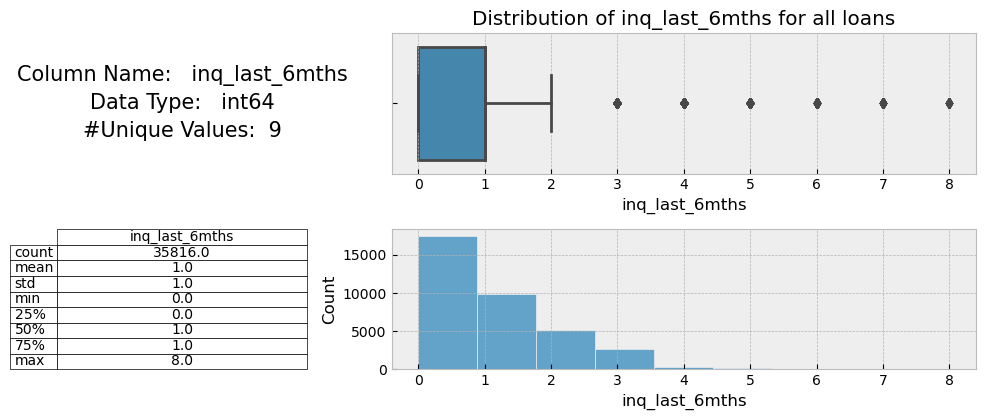

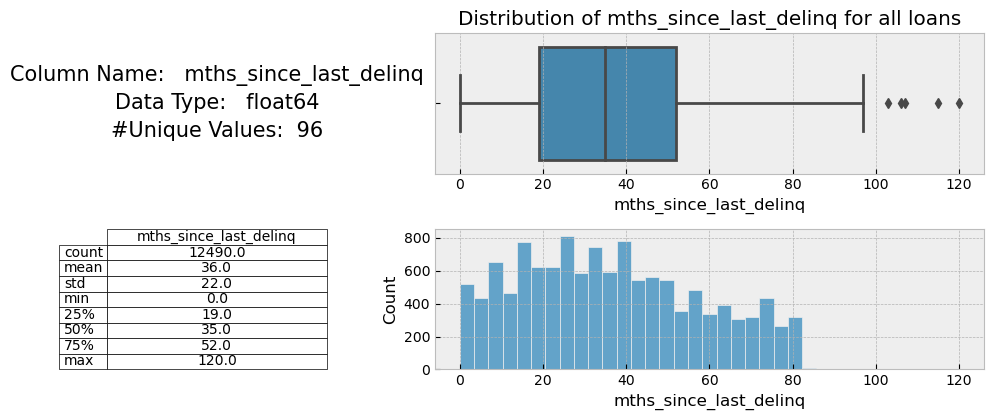

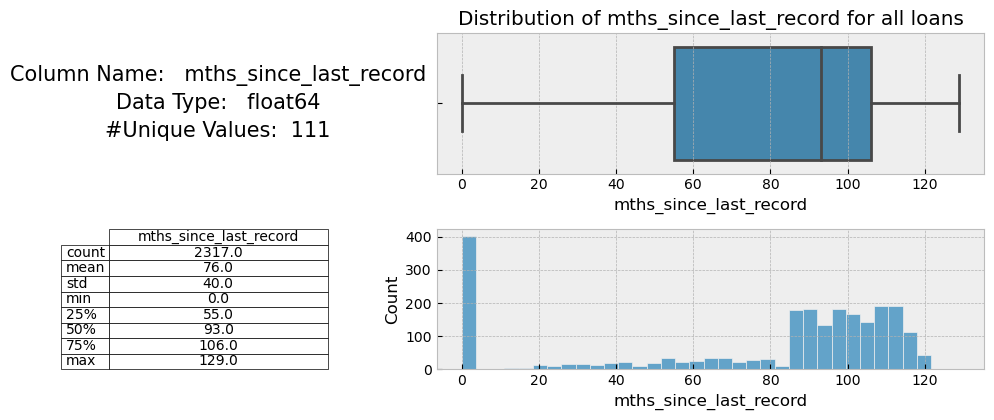

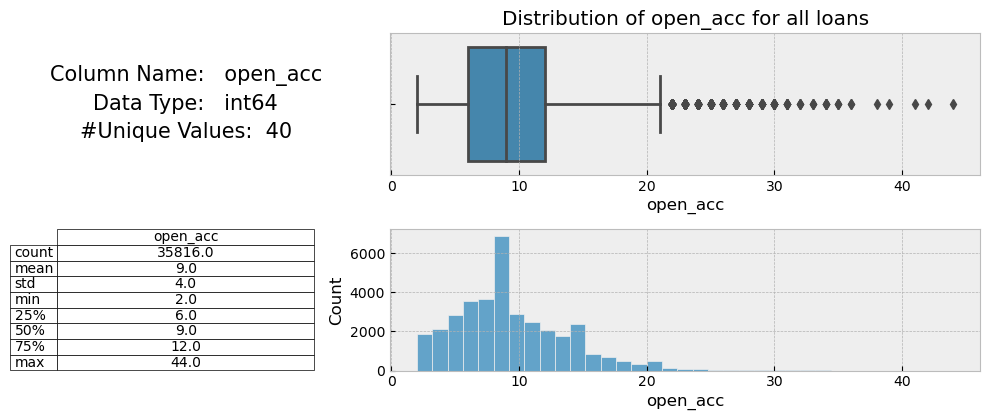

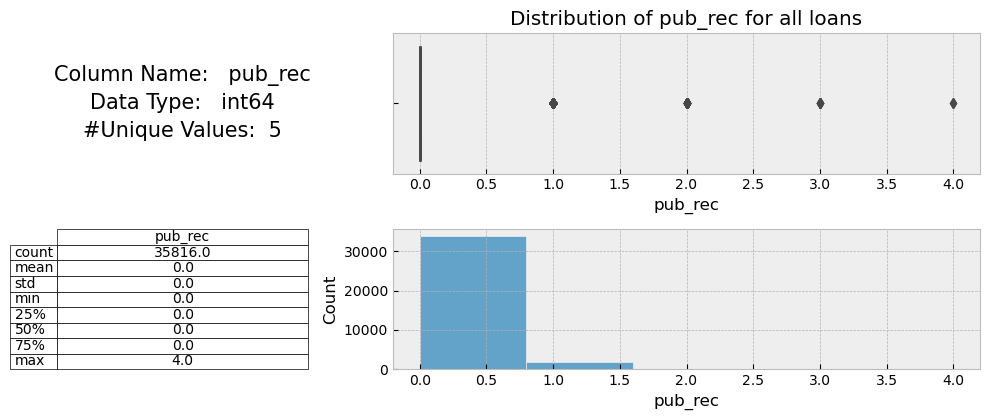

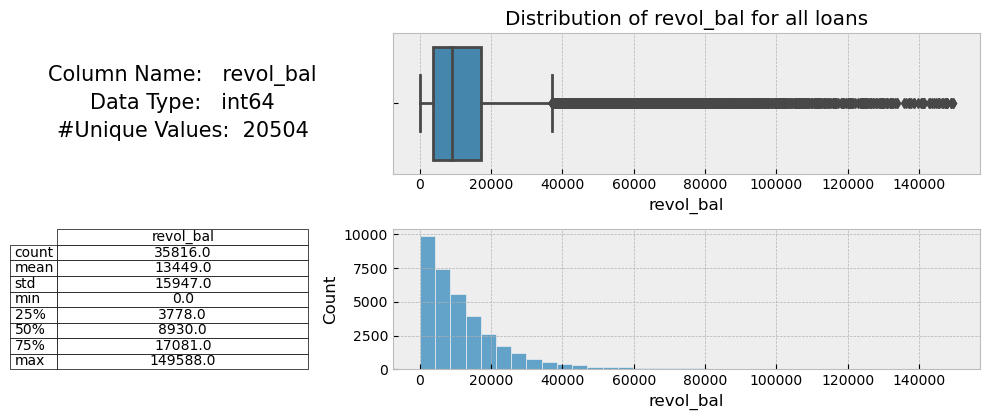

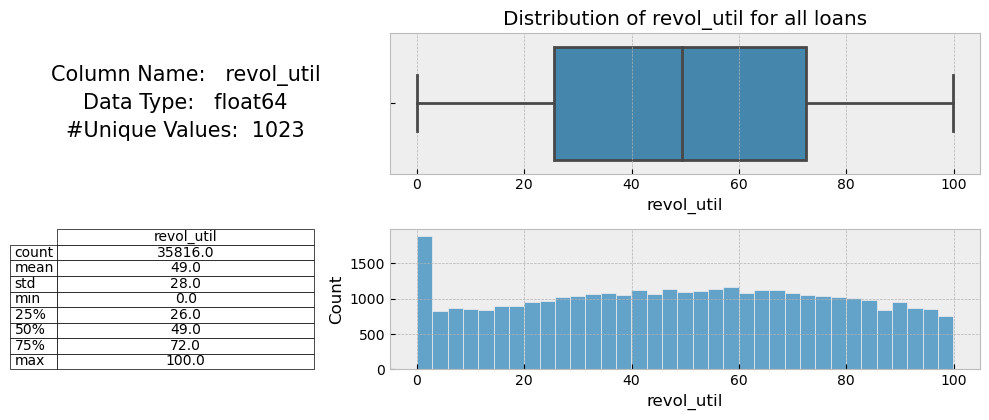

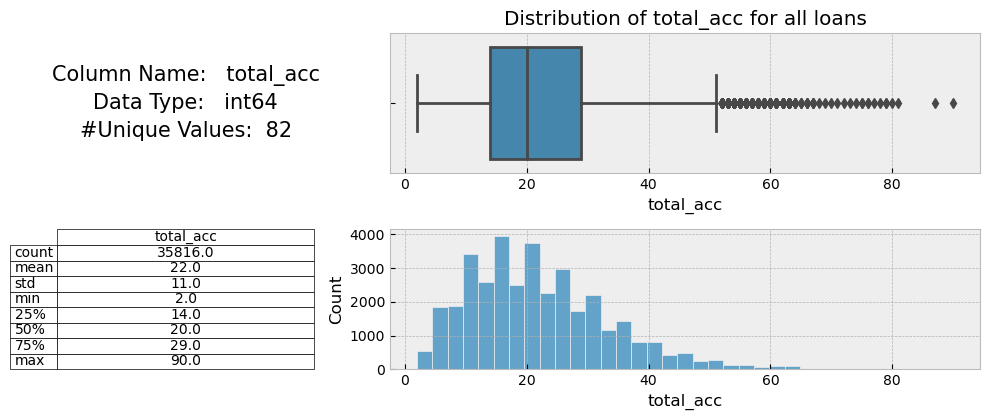

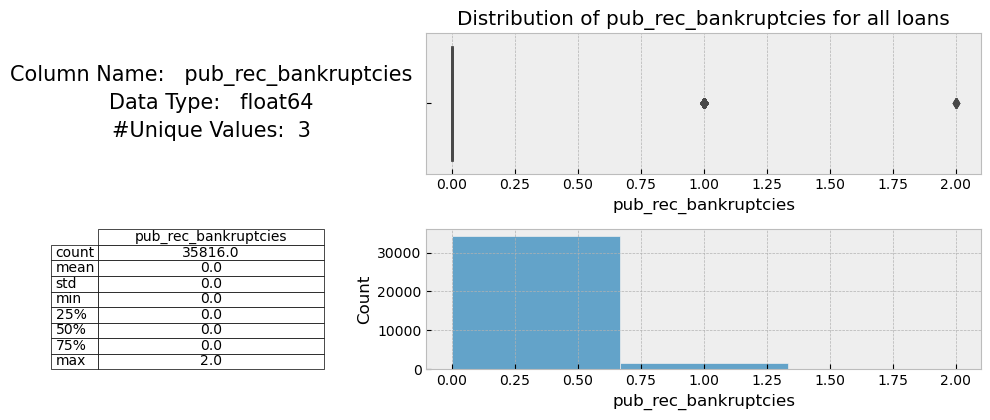

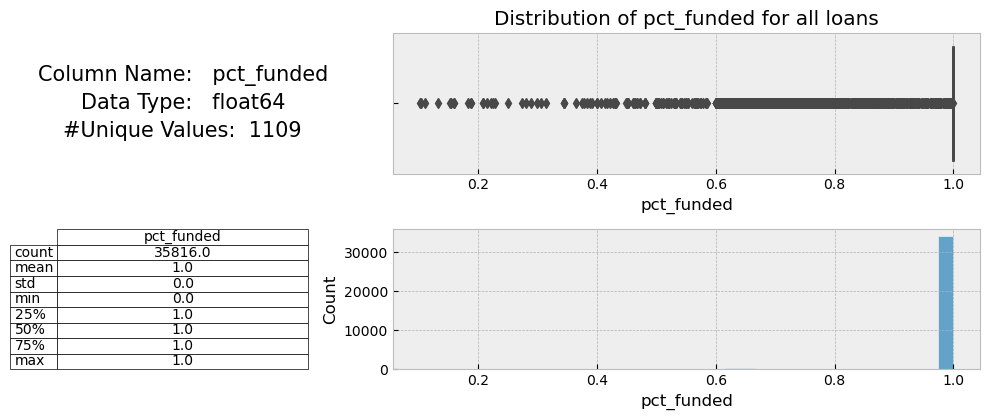

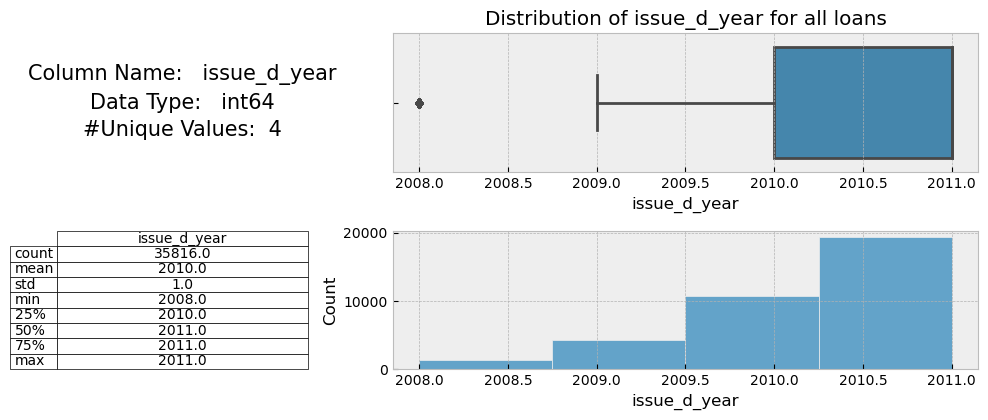

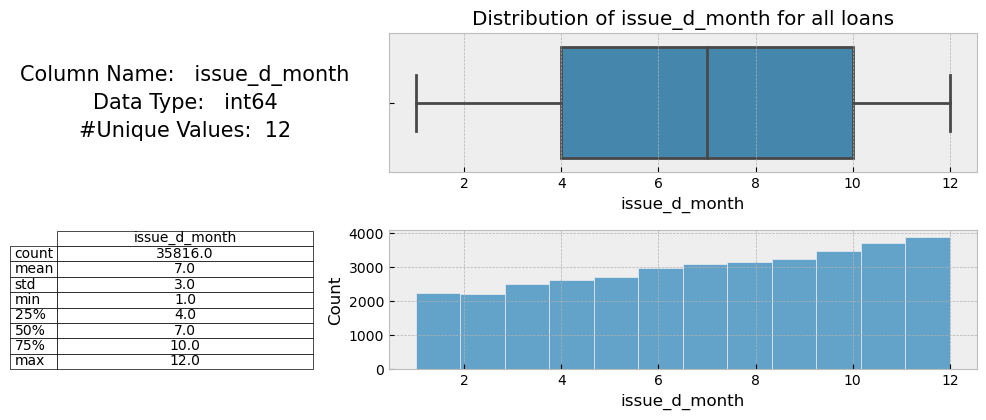

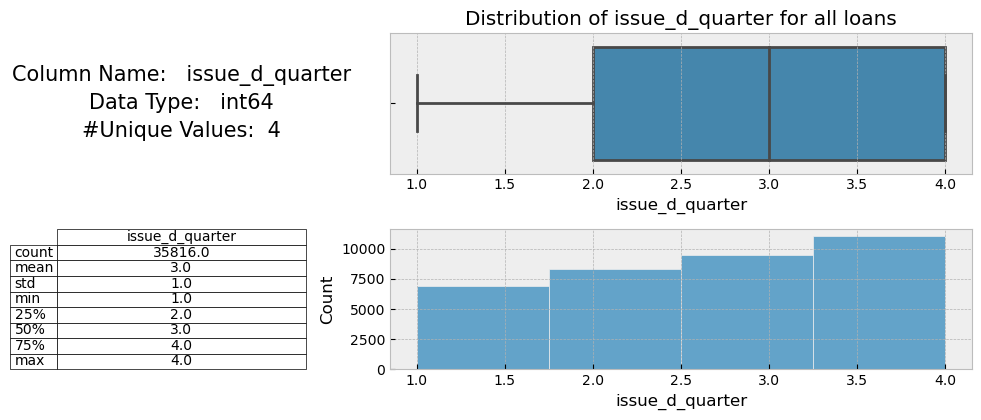

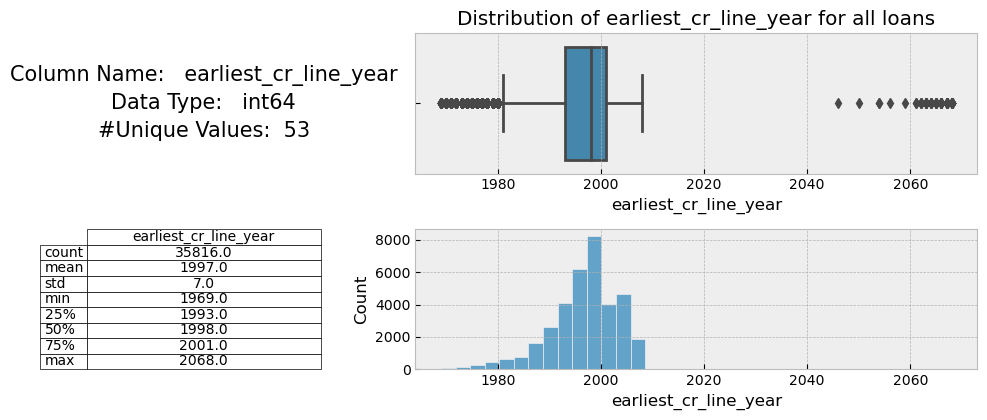

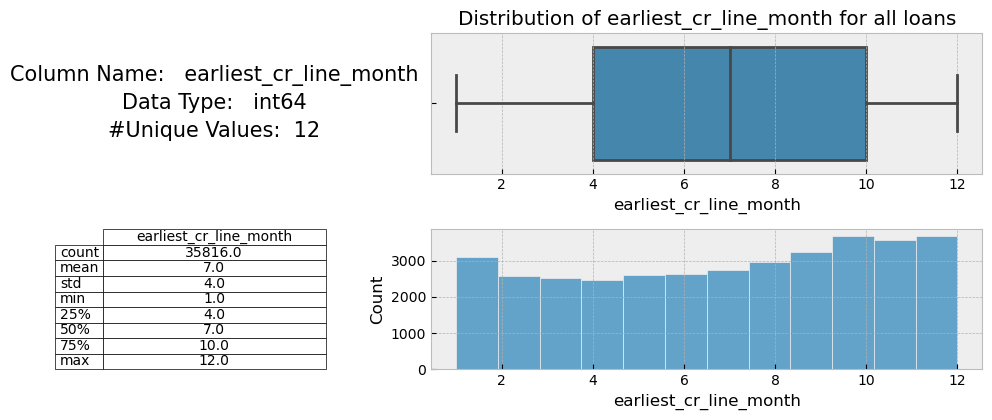

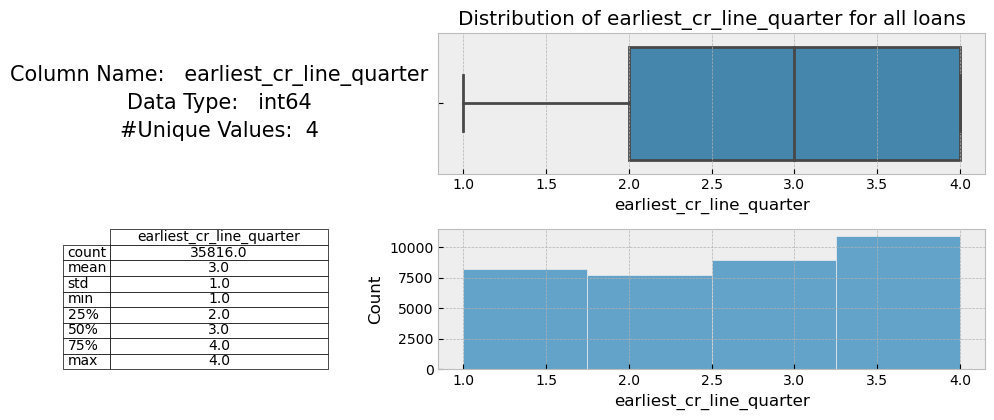

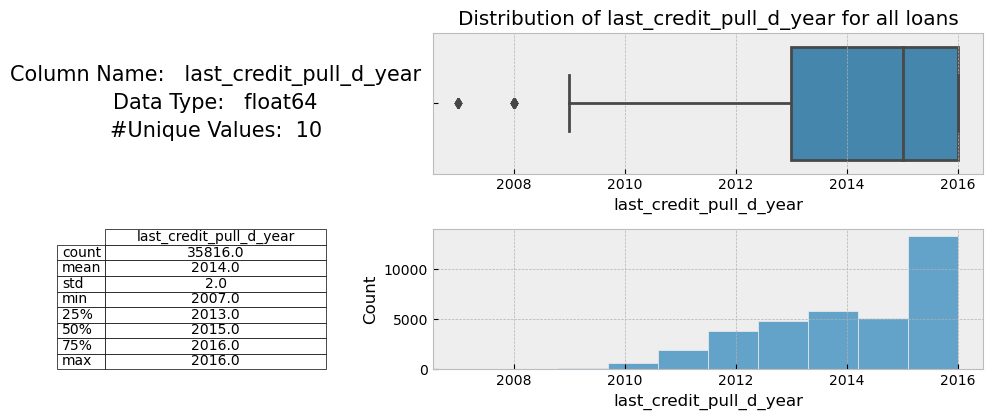

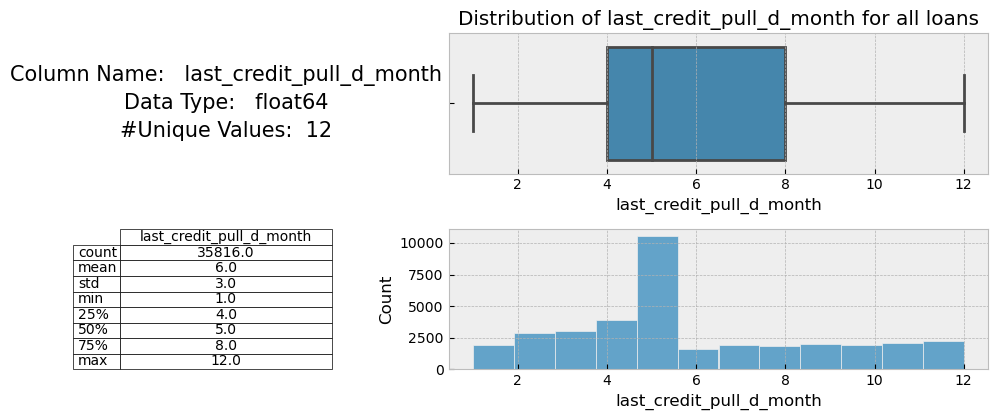

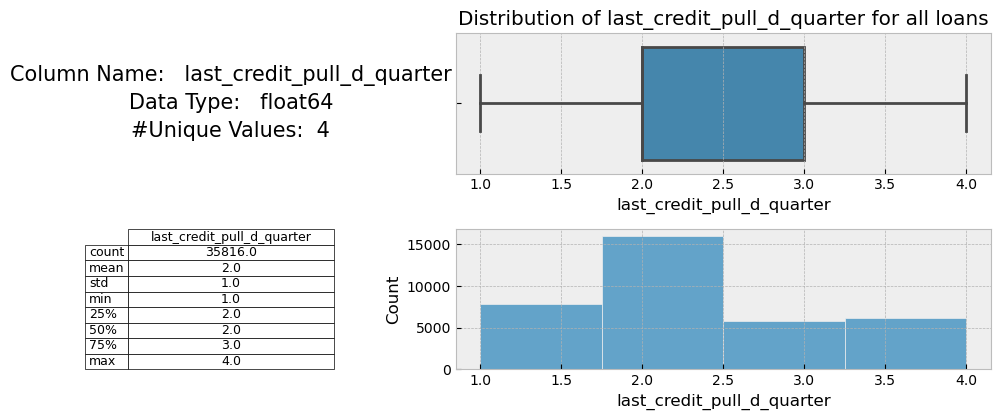

In [18]:
for col in df.columns:
    if (df[col].dtype in ['int32','Int32','int64','float64']):
        univariate_continuous_plots(col)

### This information is useful to help clean the data further

- there are rows with a lot of outliers
- there are some dates in the future

### Some patterns have also been identified that can be investigated further to see if
### they impact the probabiltiy of default

- the number of loans is increasing year on year
- the loan amount distrubtion has spikes at multiples of 5k 
- more people take loans in the last quarter of the year
- there is a spike of people pulling credit in the month of May

In [19]:
# looking at the univariate analysis some of the columns have outliers that should be removed
def remove_outliers(col,df):
    upperquartile = df[col].quantile(0.25)
    lowerquartile = df[col].quantile(0.75)
    iqrange = upperquartile - lowerquartile 
    df = df[df[col] > upperquartile + (1.5*iqrange)]
    df = df[df[col] < lowerquartile - (1.5*iqrange)]
    return df

cols = ['annual_inc','int_rate','installment','loan_amnt','revol_bal','open_acc','total_acc']
for col in cols:
    df = remove_outliers(col,df)

In [20]:
# the earliest credit line year field has some dates in the future.
# The latest date this value could be is the issue date 
print(len(df[df['earliest_cr_line']>df['issue_d']].earliest_cr_line), ' future dated earliest_cr_line found' )

# set any earliest credit line date to issue date 
# where earliest credit line date > issue date
df_copy = df.copy()
mask = (df['earliest_cr_line']>df['issue_d'])
df.loc[mask,'earliest_cr_line_year'] = df['issue_d'].dt.year
df.loc[mask,'earliest_cr_line_quarter'] = df['issue_d'].dt.quarter
df.loc[mask,'earliest_cr_line_month'] = df['issue_d'].dt.month
df.loc[mask,'earliest_cr_line'] = df['issue_d']


53  future dated earliest_cr_line found


In [21]:
# looking at the loan amt there appears to be spikes 
# at the multiples of 5k
# add a new feature to unvestigate this

df['rounded'] = df.apply(lambda x: True if x['loan_amnt']%5000 == 0 else False, axis= 1)

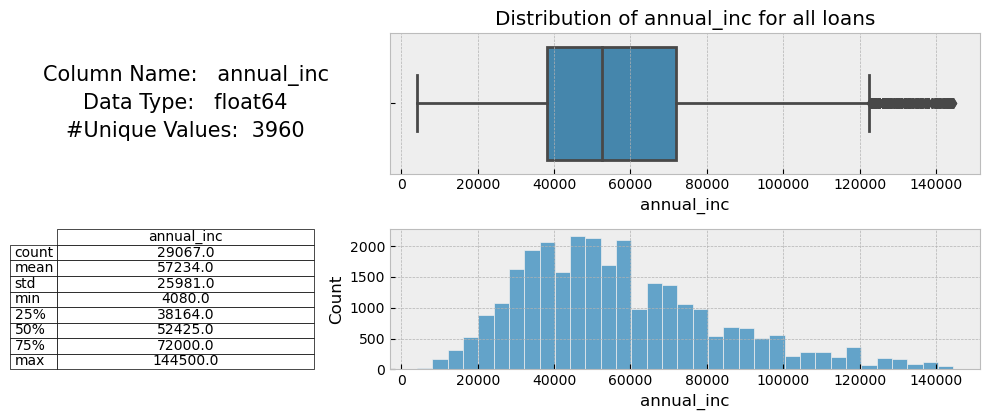

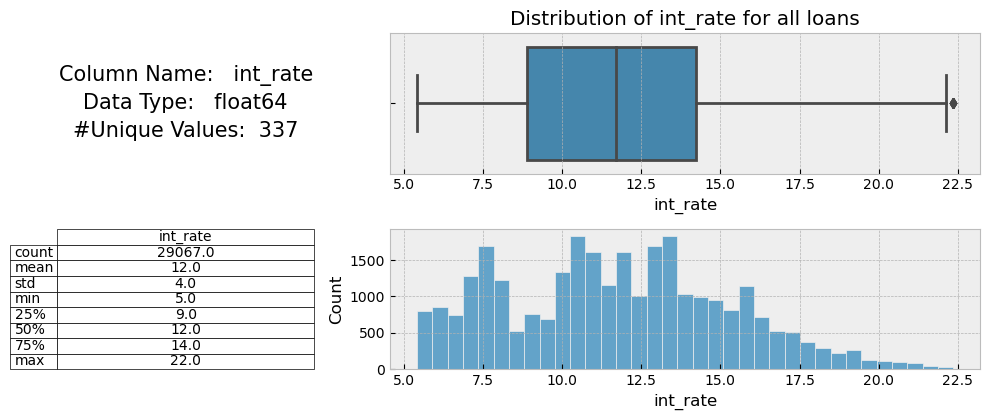

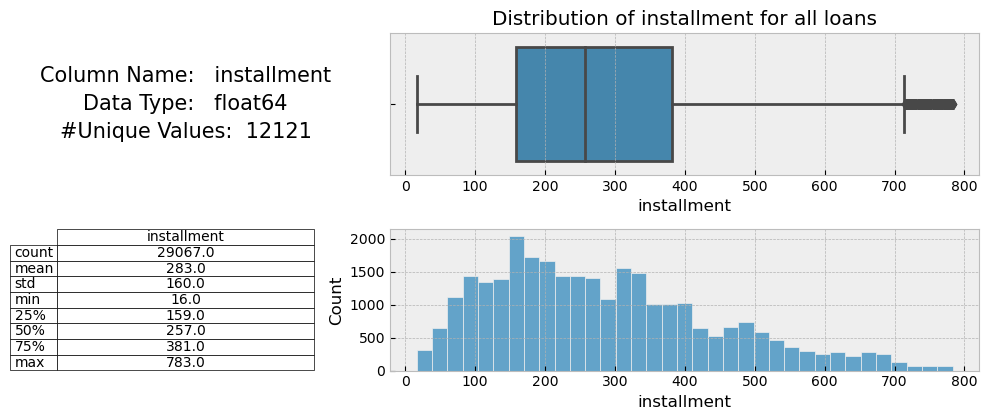

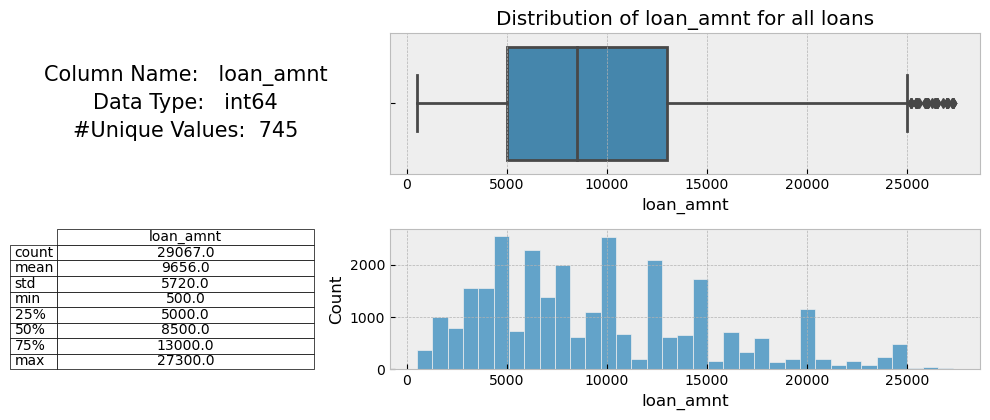

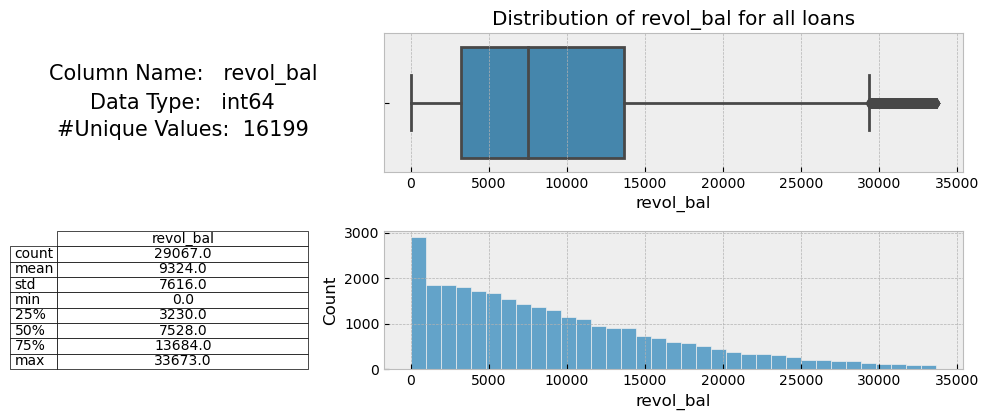

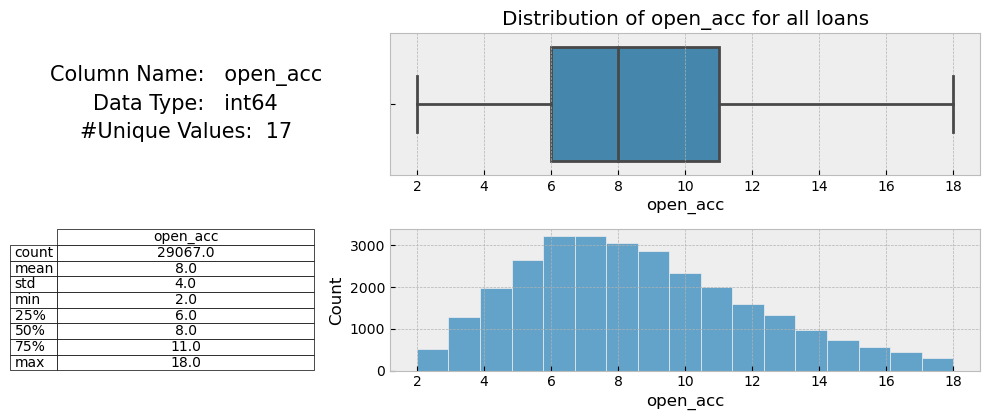

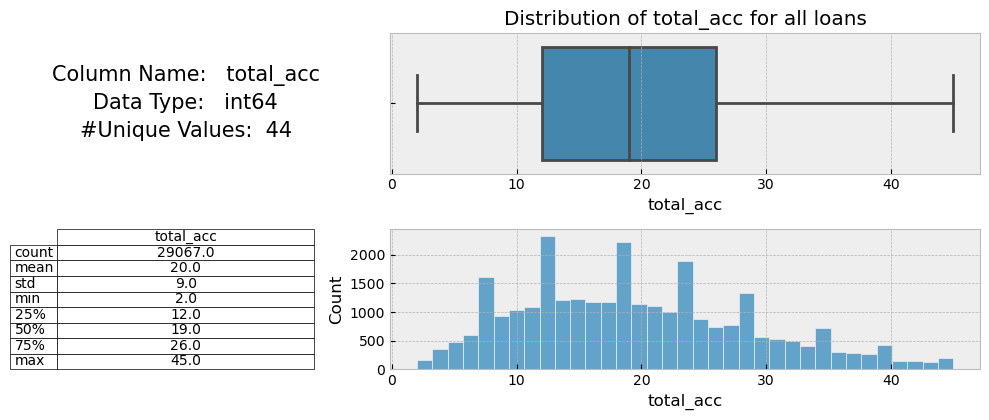

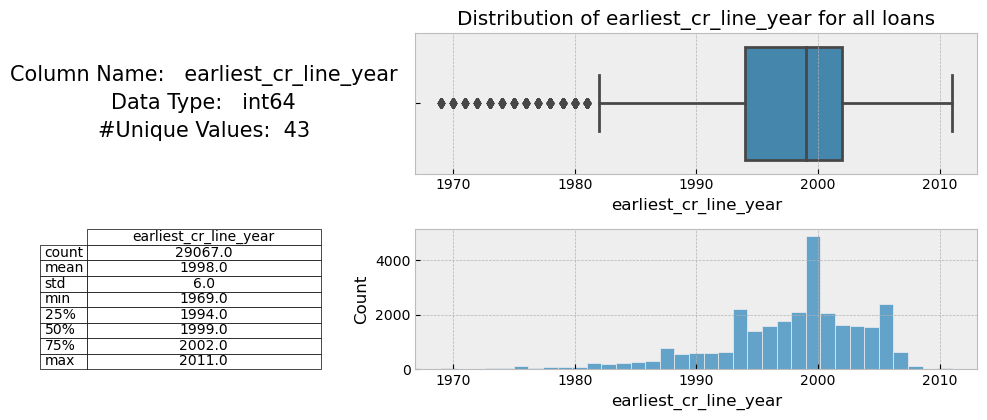

In [22]:
# Review the distributions of the cleaned data
fixed_cols = ['annual_inc','int_rate','installment','loan_amnt',
              'revol_bal','open_acc','total_acc','earliest_cr_line_year']

for col in fixed_cols:
        univariate_continuous_plots(col)

## lets look at the segmented columns in each case we will look at 
- the frequecy of loans
- frequency of defaulted loans
- percentage of loans defaulted 
- variance between the best and works categories

In [34]:
# define functions for visualisations
def univariate_segmented_plots(col):
    """ Show visualisations for segmented data
        these include
           - bar chart displaying # loans per category
           - bar chart displaying # defaulted loans per category
           - bar chart displaying % defaulted loans per category
           - a series of statistics regarding the highest and lowest % default categories
    """
    x_size = len(df[col].unique())
    if x_size < 24:
        x_size = 24

        # set the style     
    plt.style.use('bmh')

    # set up the plot layout
    fig = plt.figure(figsize=((x_size*0.3)*1.3333,10))
    fig.tight_layout()
    ax1 = plt.subplot2grid((3,3), (0,0), rowspan=3)     # left
    ax2 = plt.subplot2grid((3,3), (0,1), colspan=2)     # top right
    ax3 = plt.subplot2grid((3,3), (1,1), colspan=2)     # middle right 
    ax4 = plt.subplot2grid((3,3), (2,1), colspan=2)     # bottom right

    # Metadata
    ax1.text(0.5, 0.90, 'Column Name:   ' + col, transform=ax1.transAxes, fontsize=15,horizontalalignment='right',verticalalignment='center')
    ax1.text(0.5, 0.80, 'Data Type:   ' + str(df[col].dtype) , transform=ax1.transAxes, fontsize=15,horizontalalignment='right',verticalalignment='center')
    ax1.text(0.5, 0.70, '#Unique Values:  ' + str(len(df[col].unique())) , transform=ax1.transAxes, fontsize=15,horizontalalignment='right',verticalalignment='center')

    # Build the table
    grouping = pd.DataFrame(df[['defaulted',col]].groupby(by=col).mean())
    grouping['defaulted'] = round(grouping['defaulted']*100,2)

    cat_min = grouping['defaulted'].min()
    cat_min_group = grouping[grouping['defaulted'] == cat_min].index[0]
    cat_max = grouping['defaulted'].max()
    cat_max_group = grouping[grouping['defaulted'] == cat_max].index[0]
    cat_range = round(cat_max - cat_min,2)

    data = {'Value' : [str(cat_min) + '%', str(cat_max) + '%', cat_range],
            'Group' : [cat_min_group, cat_max_group, '-' ]}
    index = ['Min default rate','Max default rate','Default rate range']
    stats_table = pd.DataFrame(data,index=index)
    table = ax1.table(cellText=stats_table.values, colLabels=stats_table.columns, rowLabels=stats_table.index, loc='left',cellLoc='center' )
    ax1.axis('off')


    # group frequency
    df[col].value_counts().plot.bar(ax=ax2)
    ax2.set_xlabel(col)
    ax2.set_ylabel('# loans')
    ax2.set_title('Number of Loans by ' + col)
    ax2.axis('auto')
    ax2.set_xlabel('')


    # group default frequency
    grouping = pd.DataFrame(df[['defaulted',col]].groupby(by=col).sum())
    grouping = grouping.sort_values('defaulted',ascending=False)
    grouping['defaulted'] = round(grouping['defaulted'],2)
    grouping['defaulted'].plot.bar(ax=ax3)
    ax3.set_ylabel('# defaulted')
    ax3.set_title('Number of defaults by ' + col)
    ax3.set_xlabel('')

    # group default %
    grouping = pd.DataFrame(df[['defaulted',col]].groupby(by=col).mean())
    grouping = grouping.sort_values('defaulted',ascending=False)
    grouping['defaulted'] = round(grouping['defaulted']*100,2)
    grouping['defaulted'].plot.bar()
    ax4.set_ylabel(' Default %')
    plt.axhline(y=df['defaulted'].mean()*100, color='r',linestyle='--')
    ax4.set_title('default % by ' + col)

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()





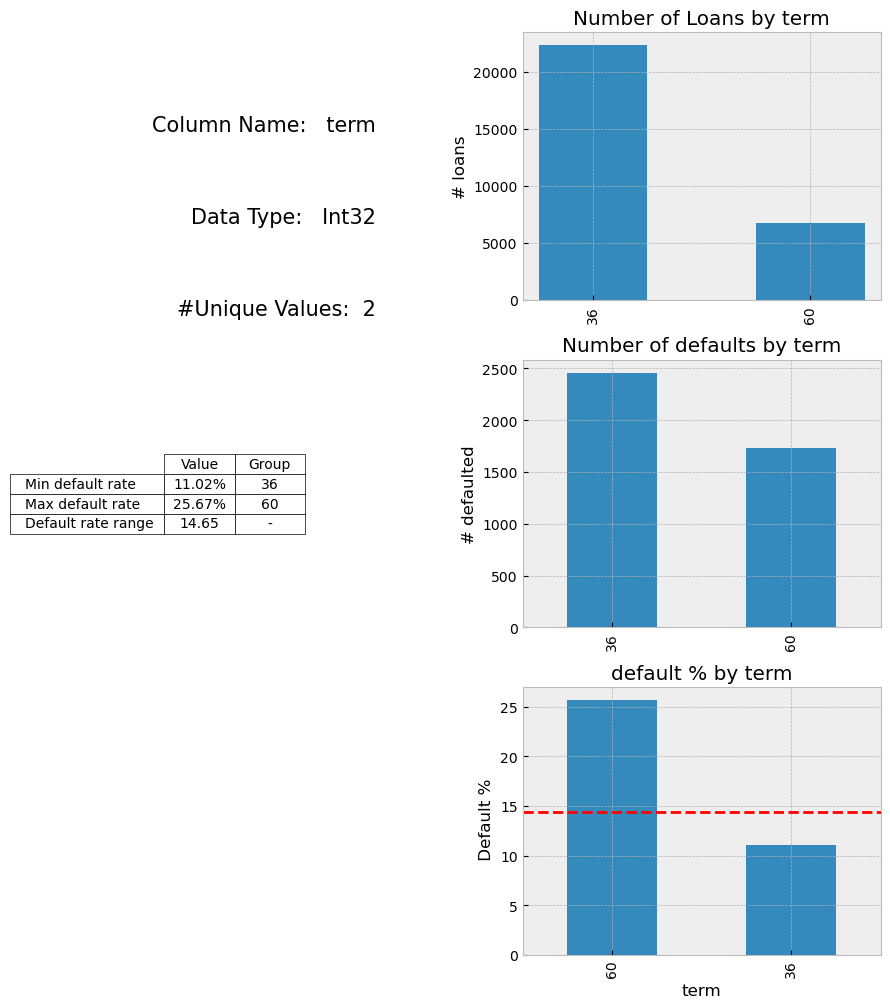

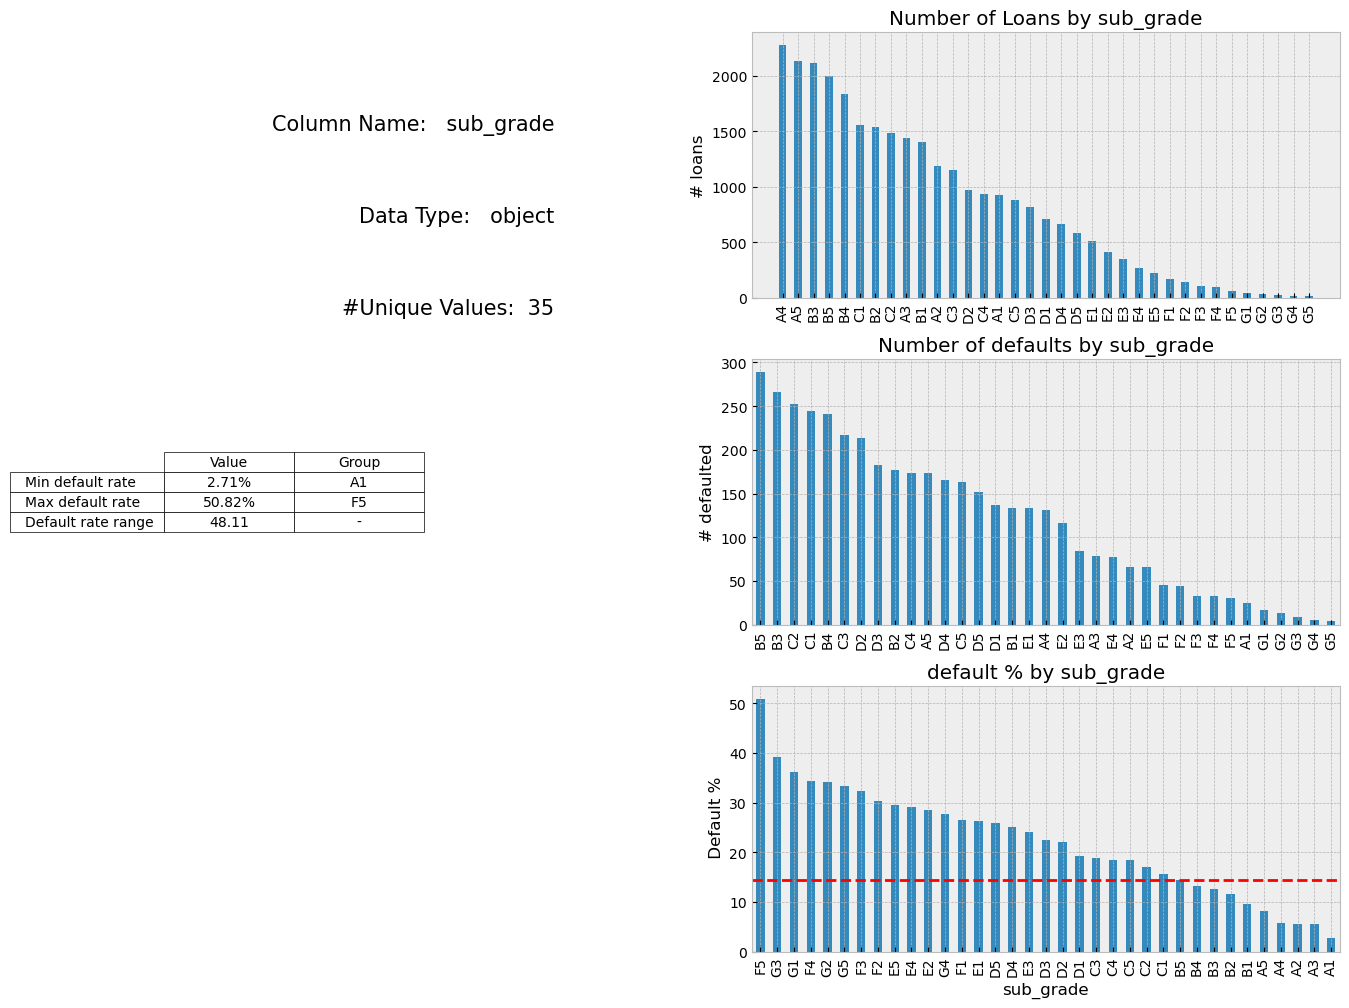

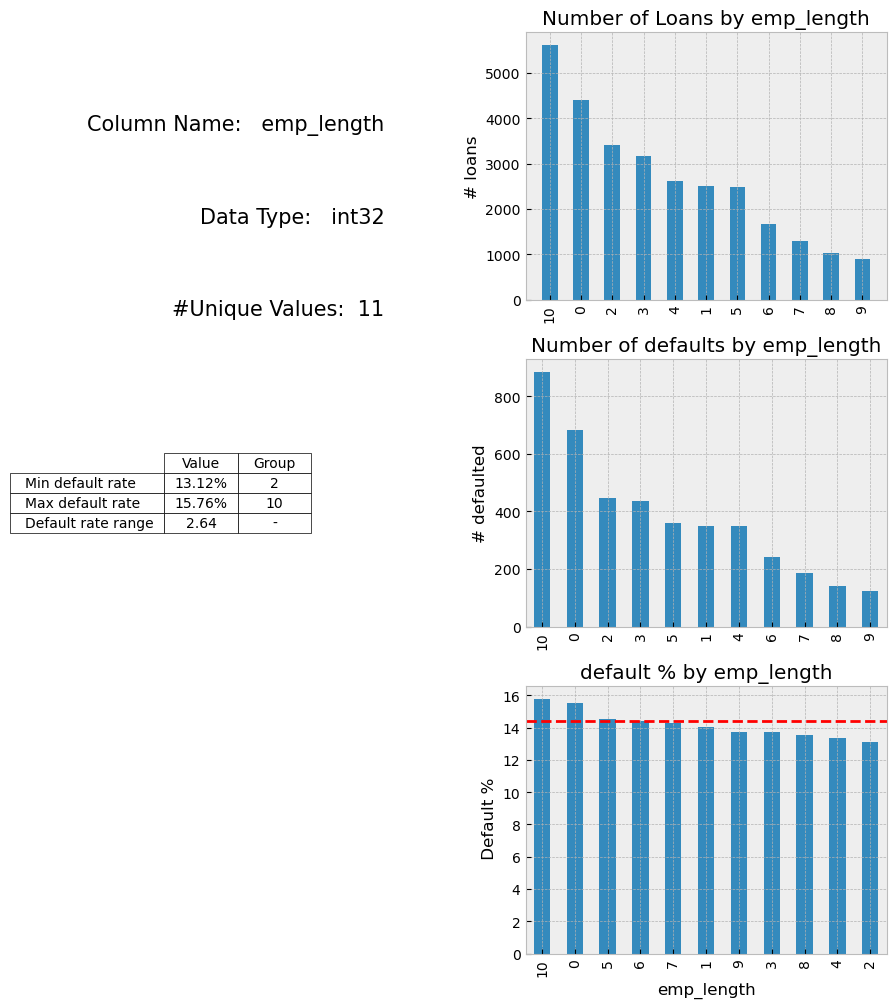

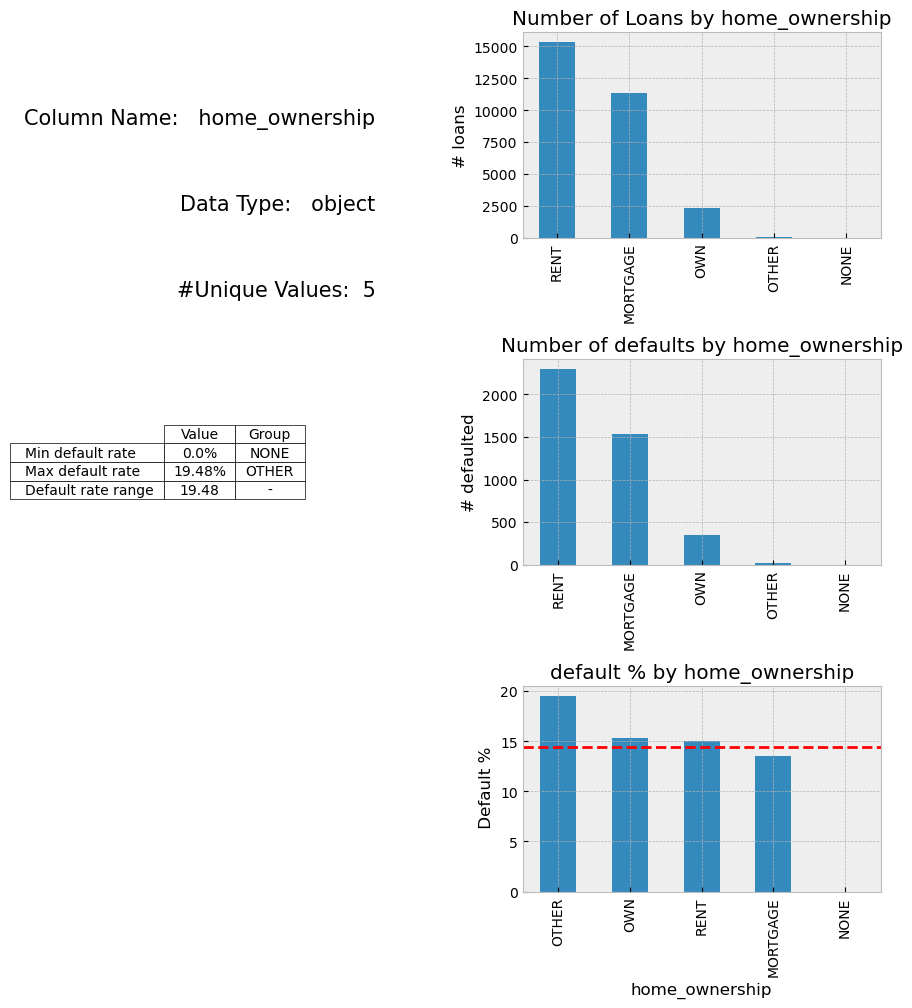

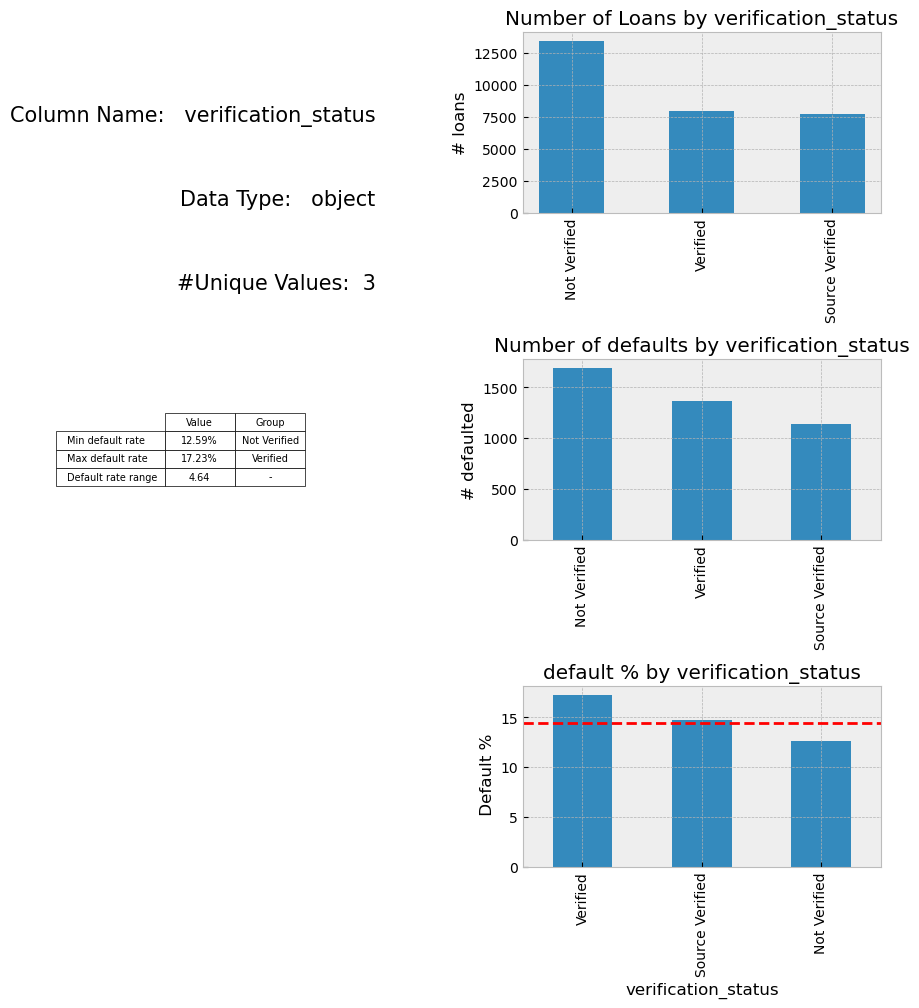

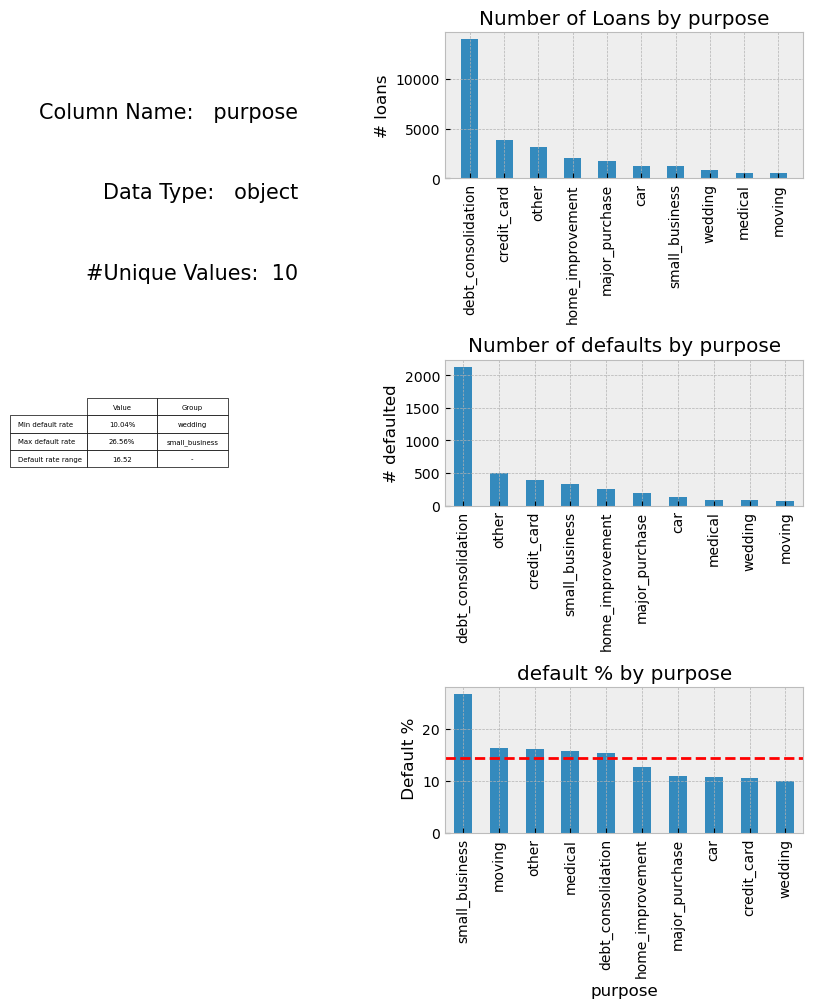

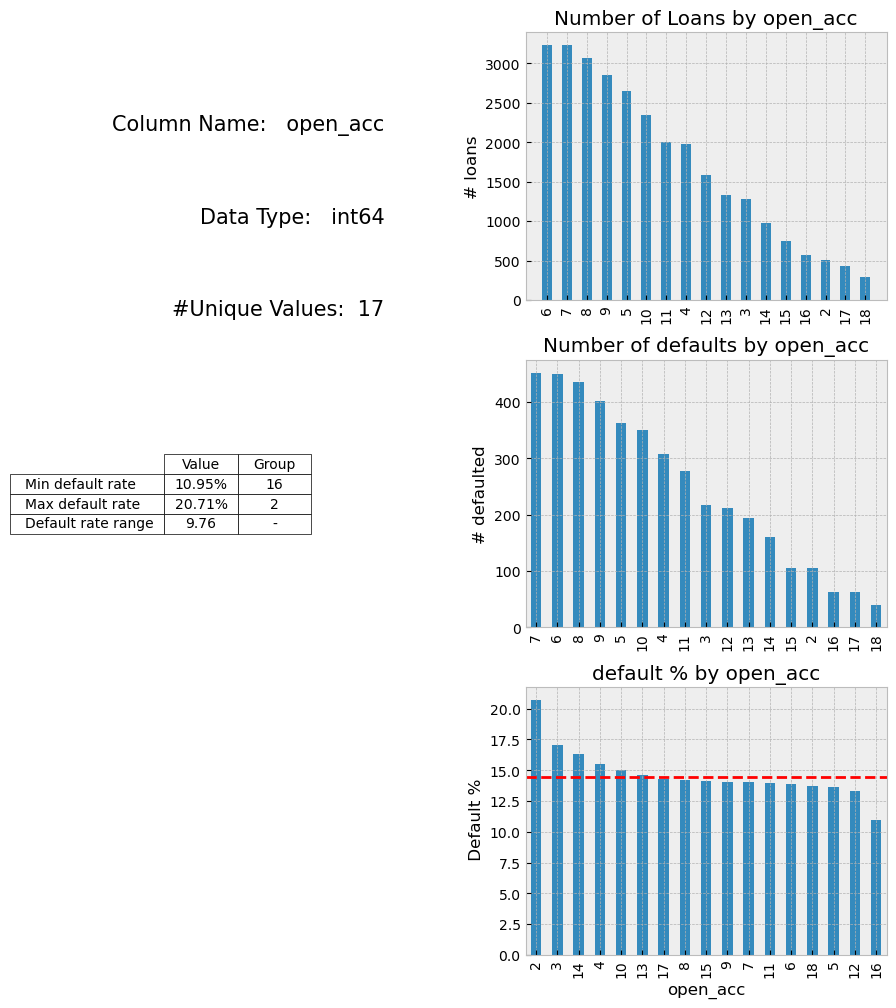

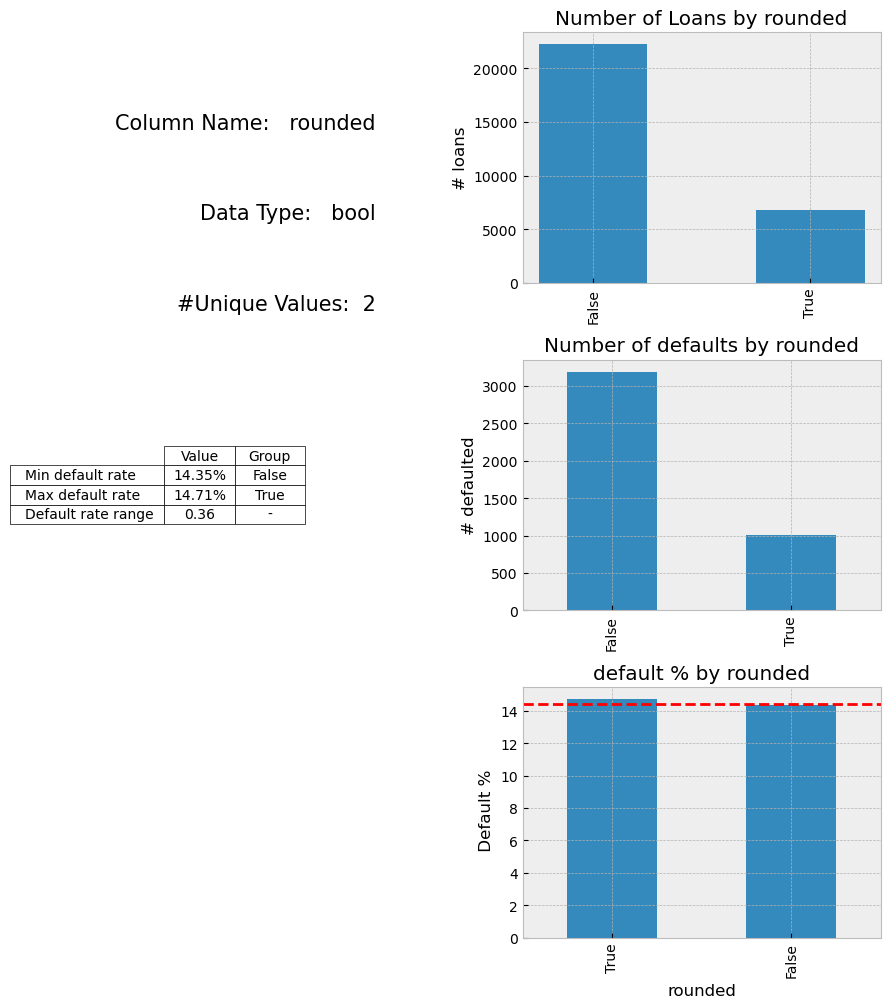

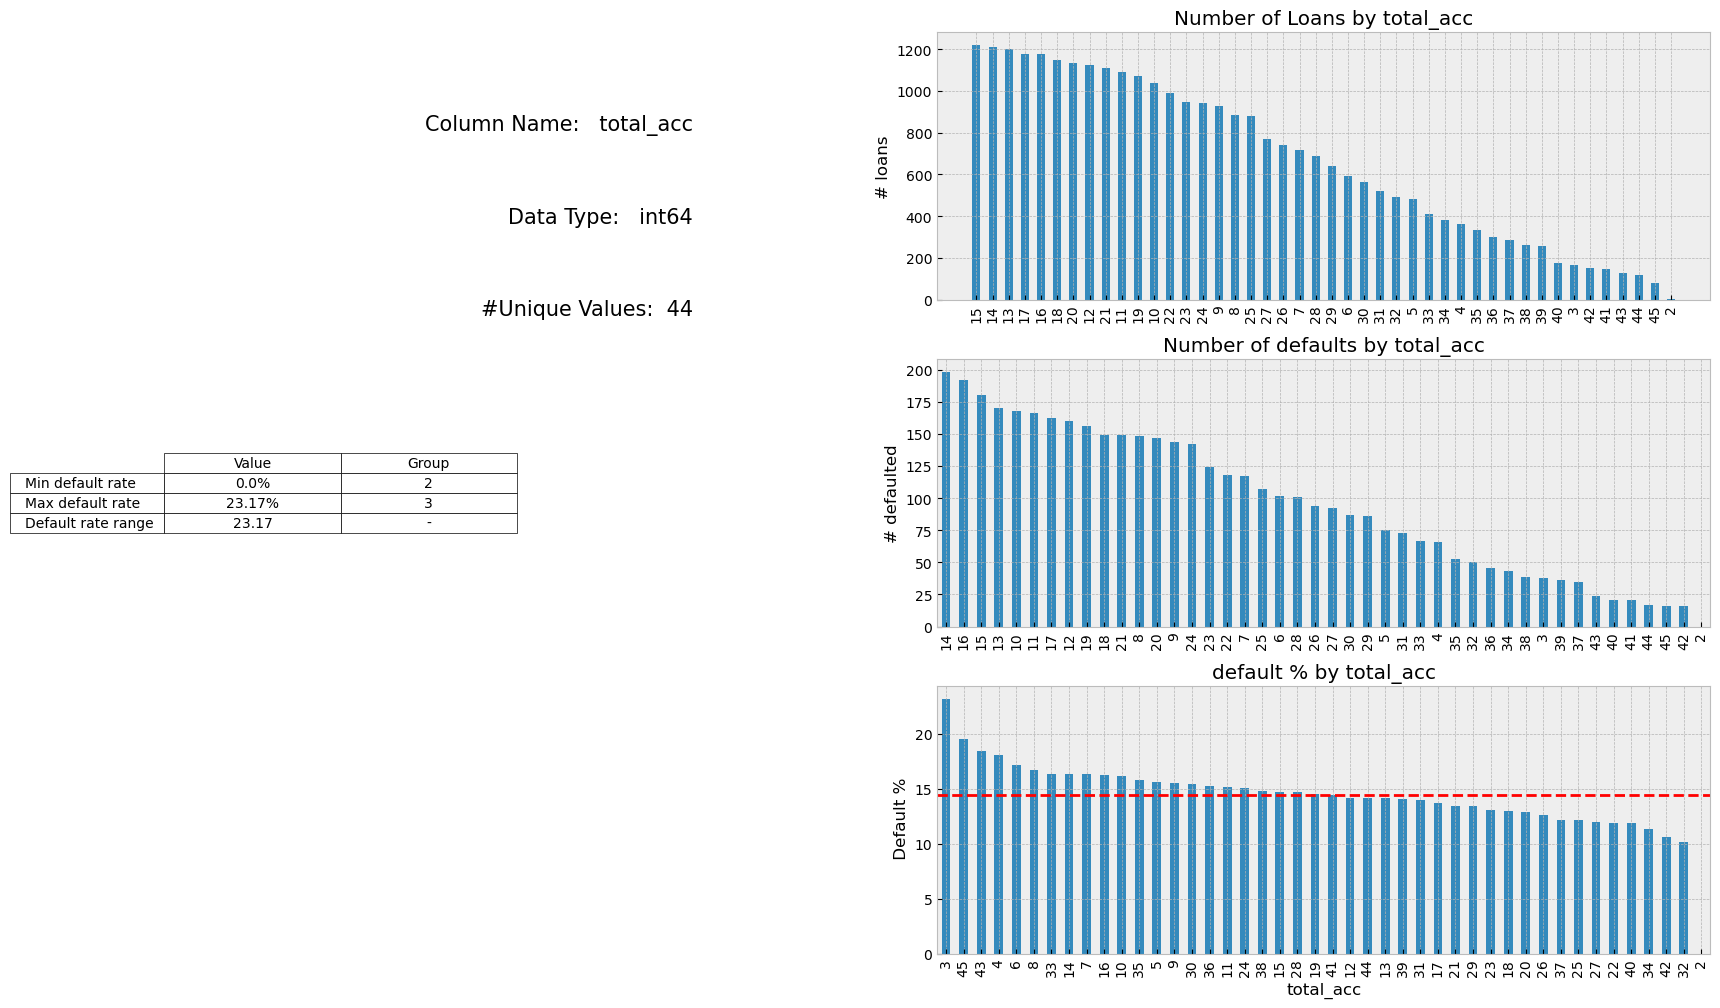

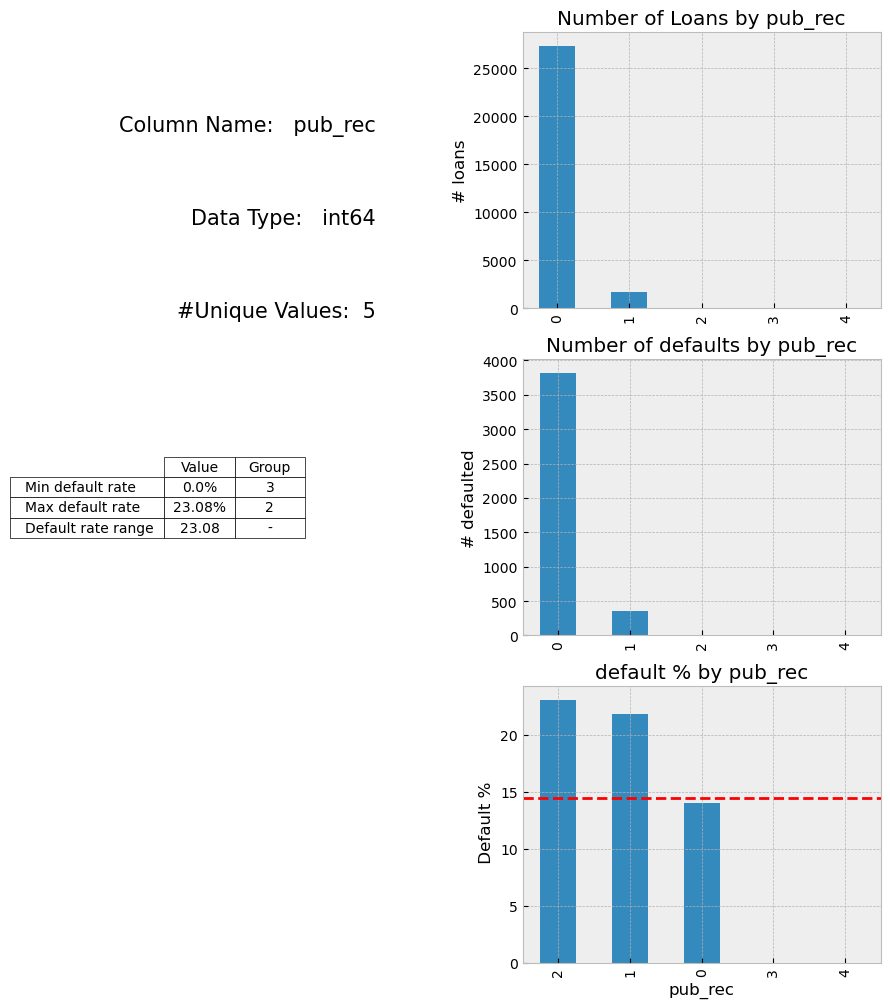

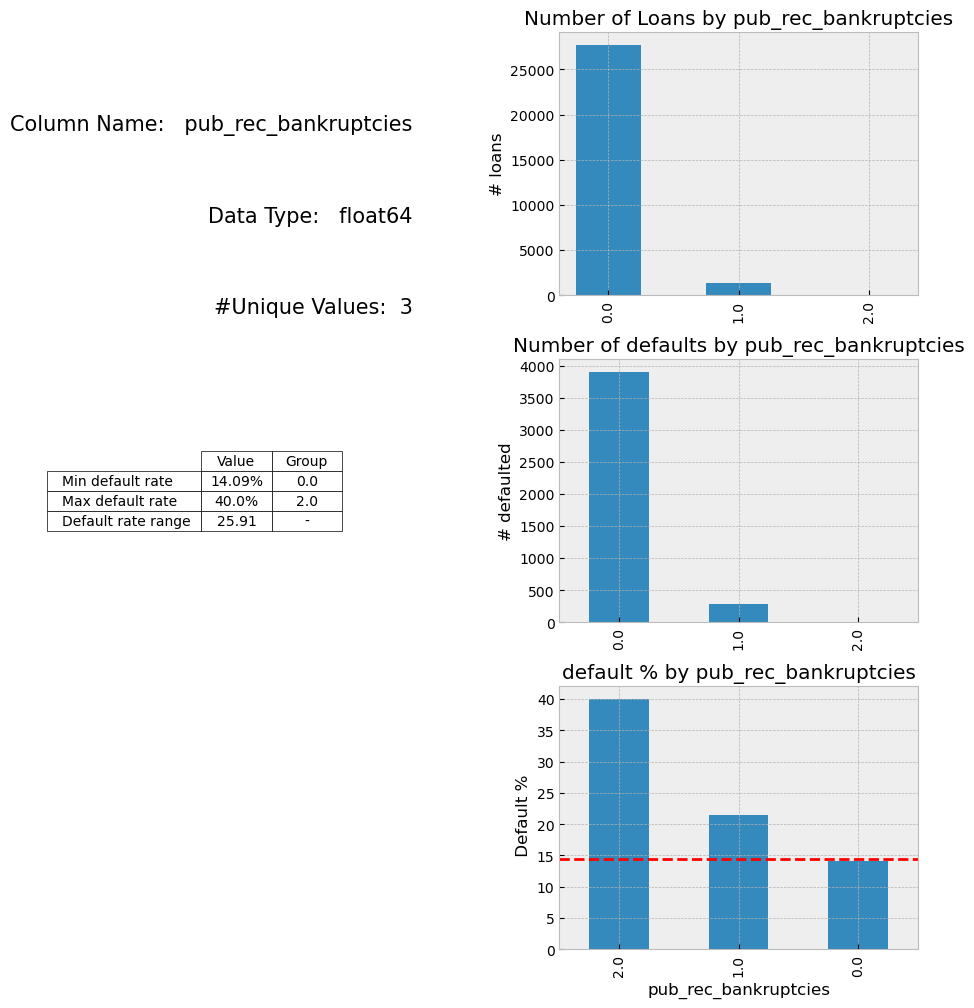

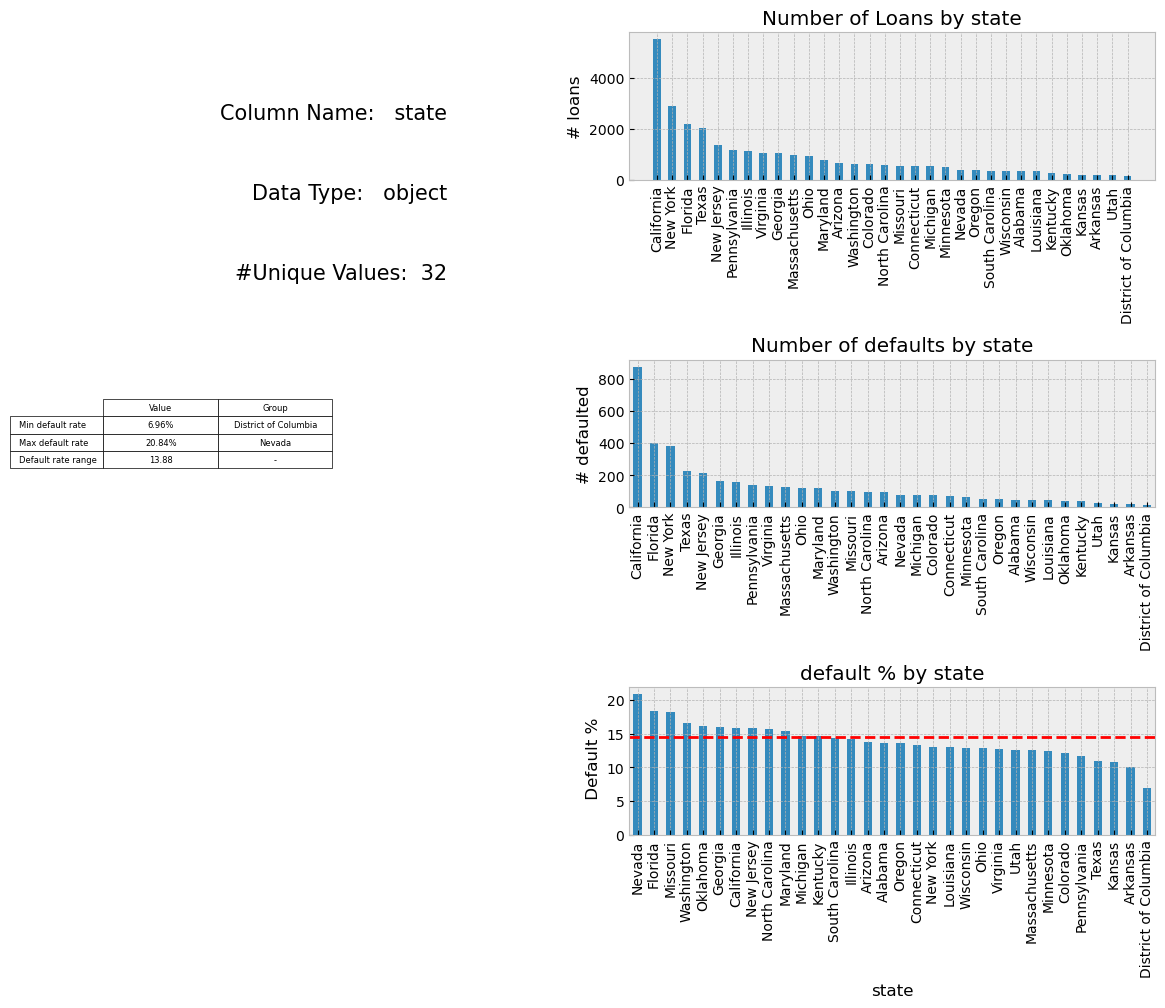

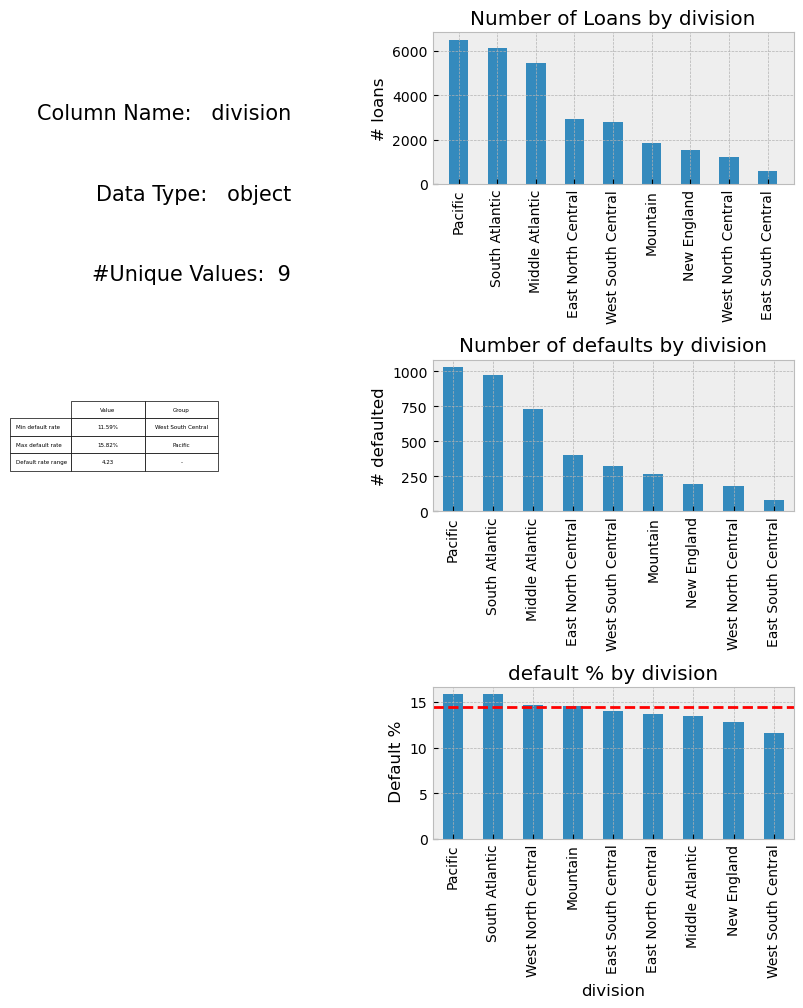

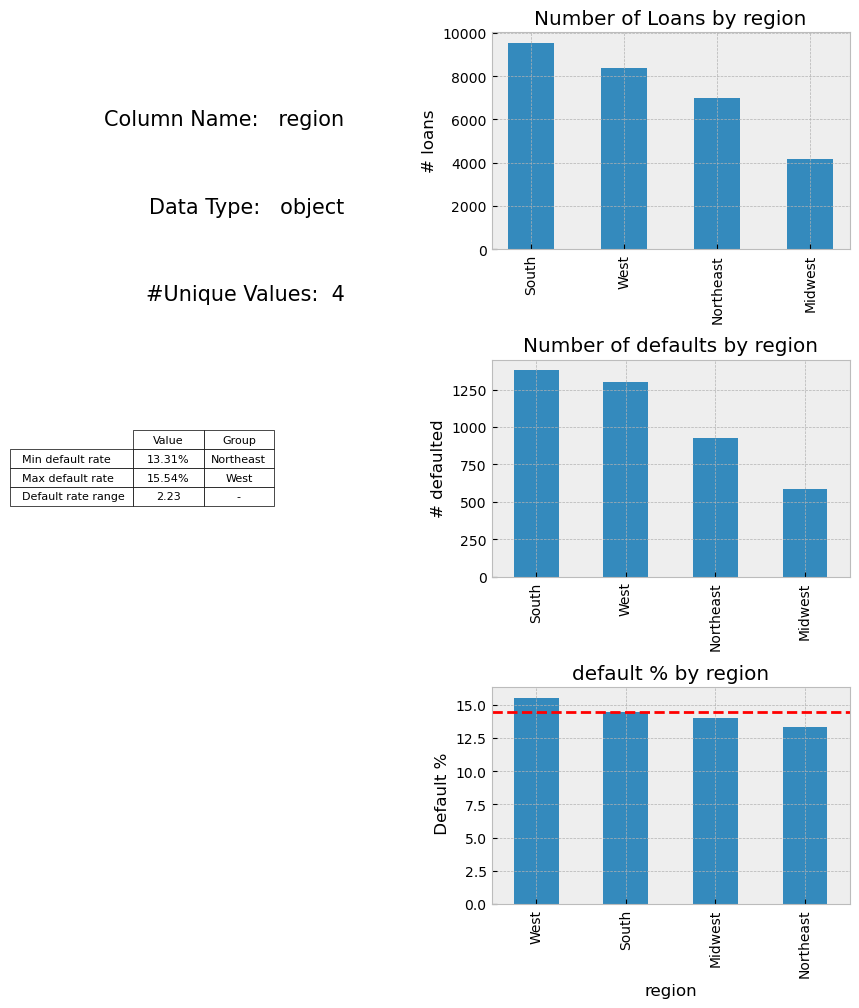

In [35]:
# generate the plots for the selected categorical fields
segmented_list = ['term','sub_grade','emp_length','home_ownership',
                    'verification_status','purpose','open_acc','rounded',
                    'total_acc','pub_rec','pub_rec_bankruptcies',
                    'state','division','region']

for col in segmented_list:
    univariate_segmented_plots(col)

### Looking at these results the following categorical data looks relavent 
### due to the variation of the default % for the values 

- Term
- Sub-grade
- Home ownership
- Purpose
- Open acc
- pub_rec
- pub_rec_bankruptcies
- region
- division
- state

### Looking at the data it appears loans rounded to the nearest
### 5k has little impact on the default rate

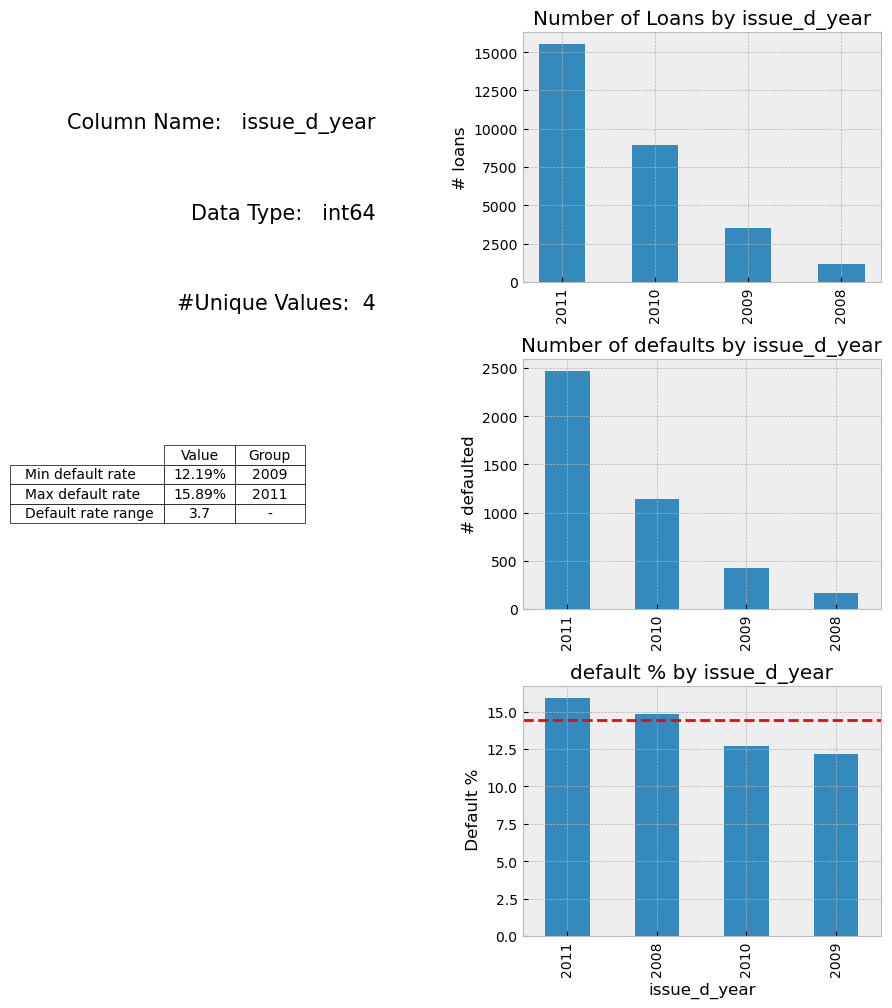

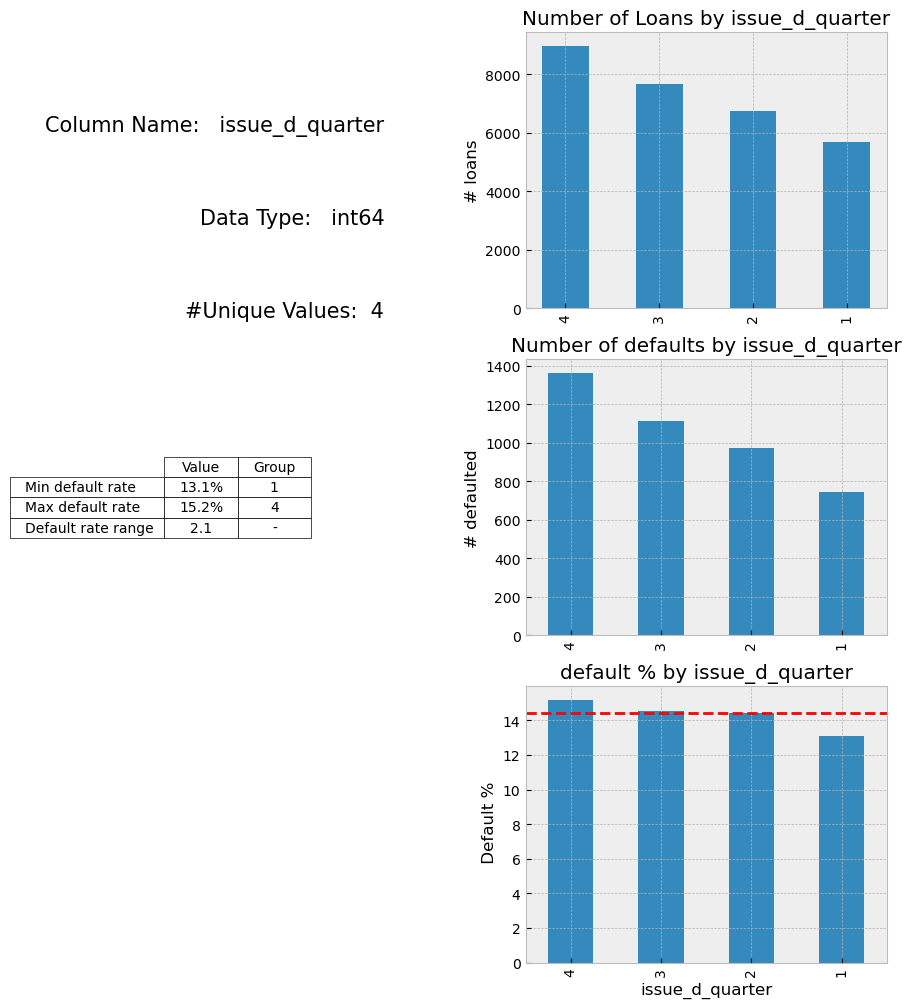

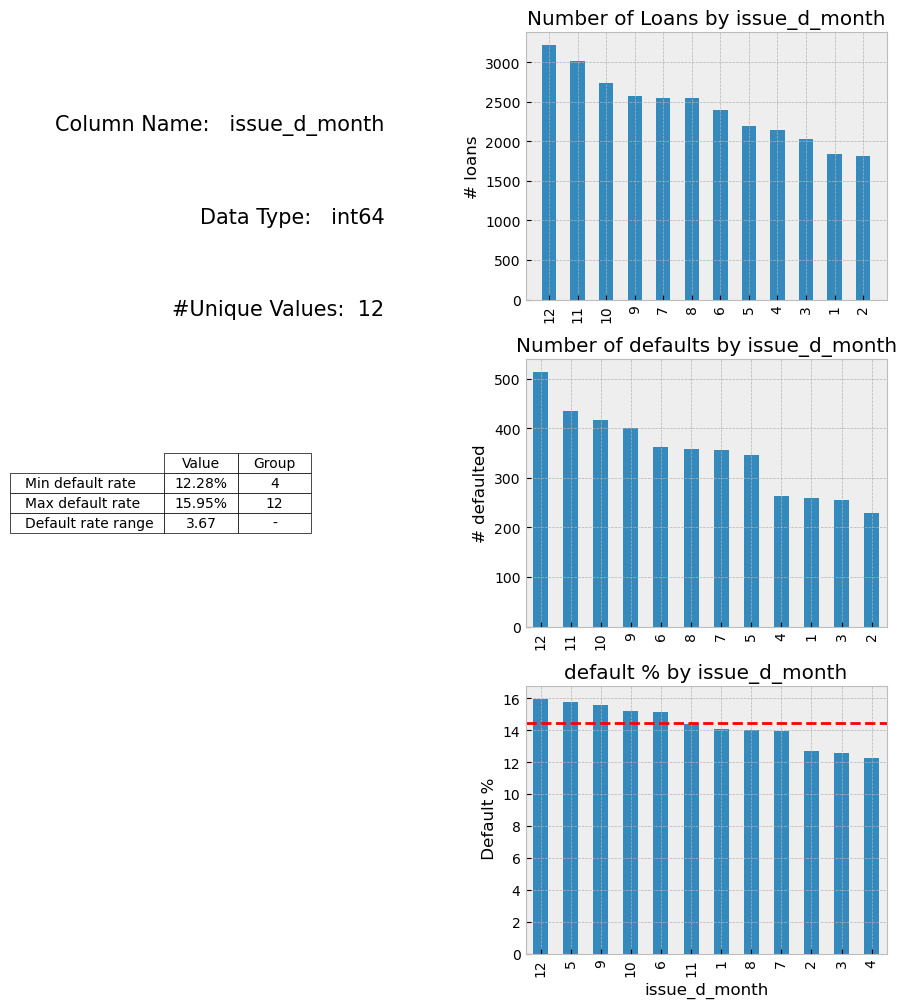

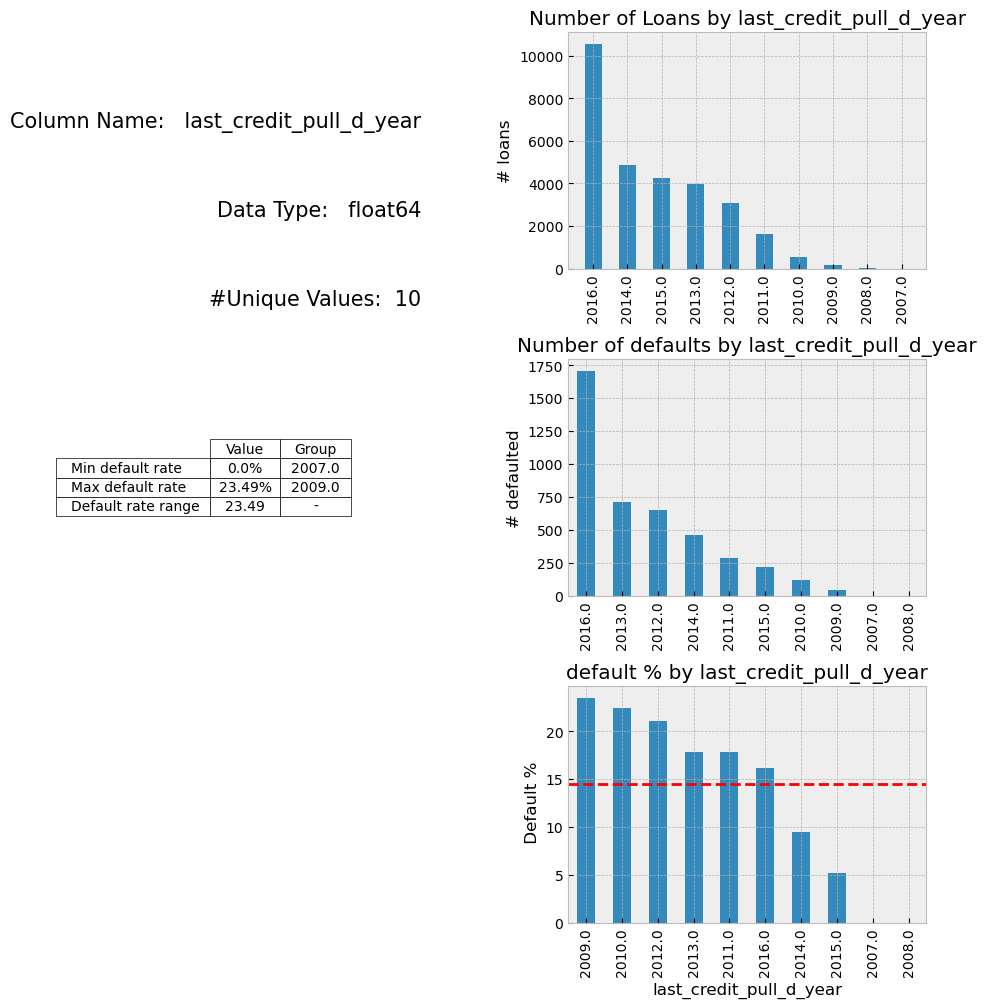

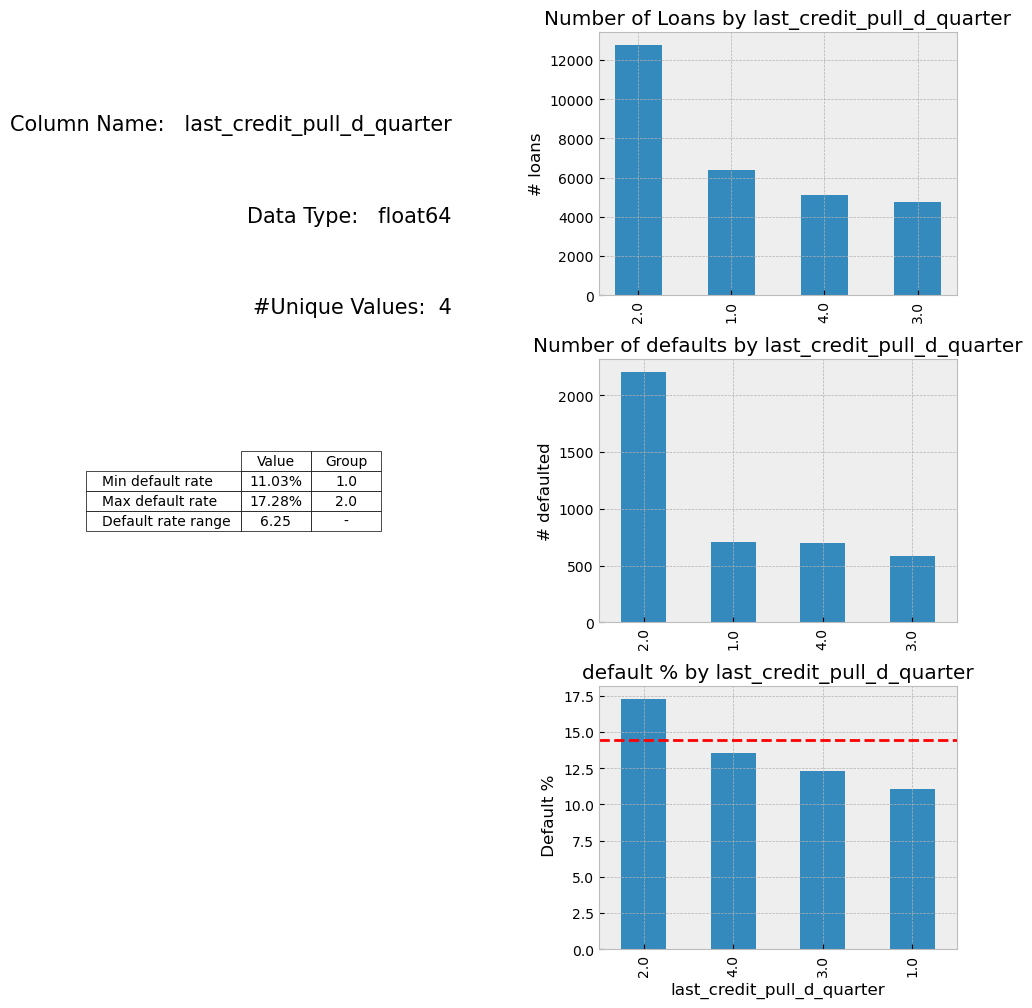

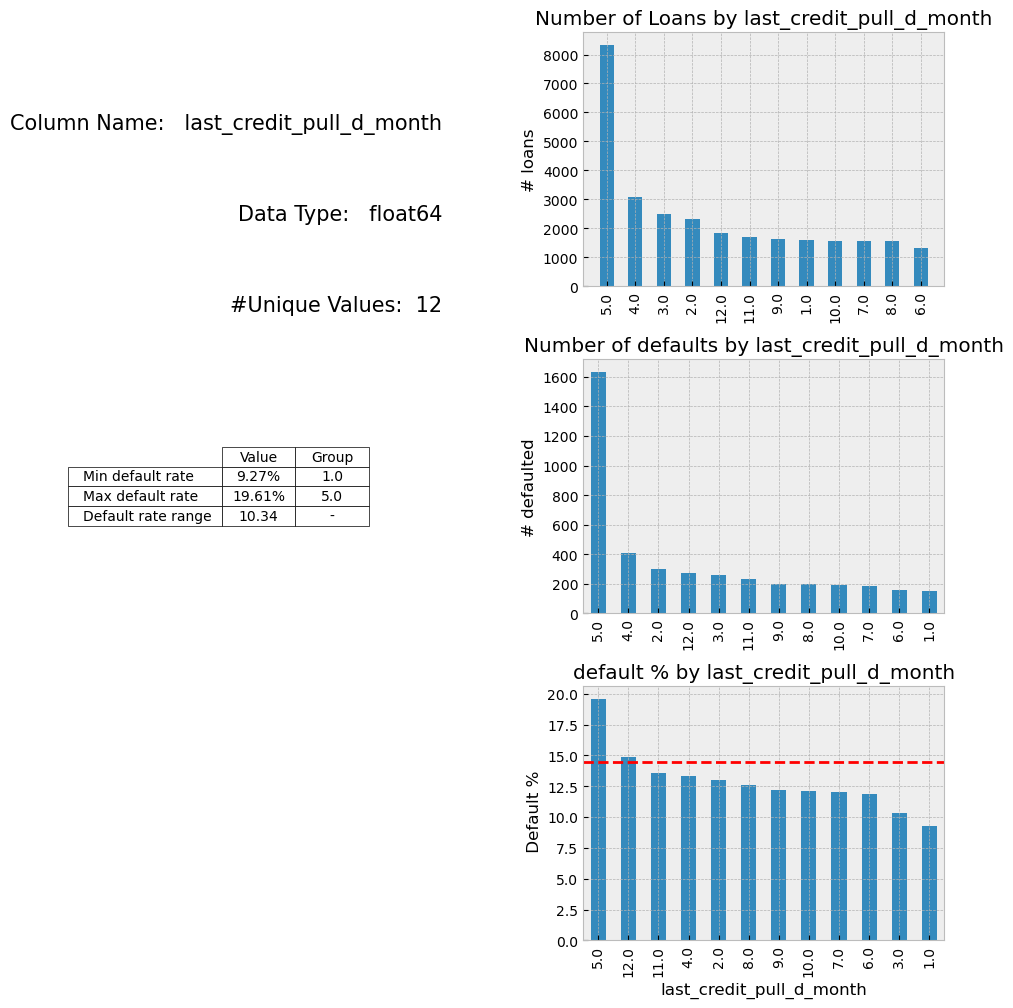

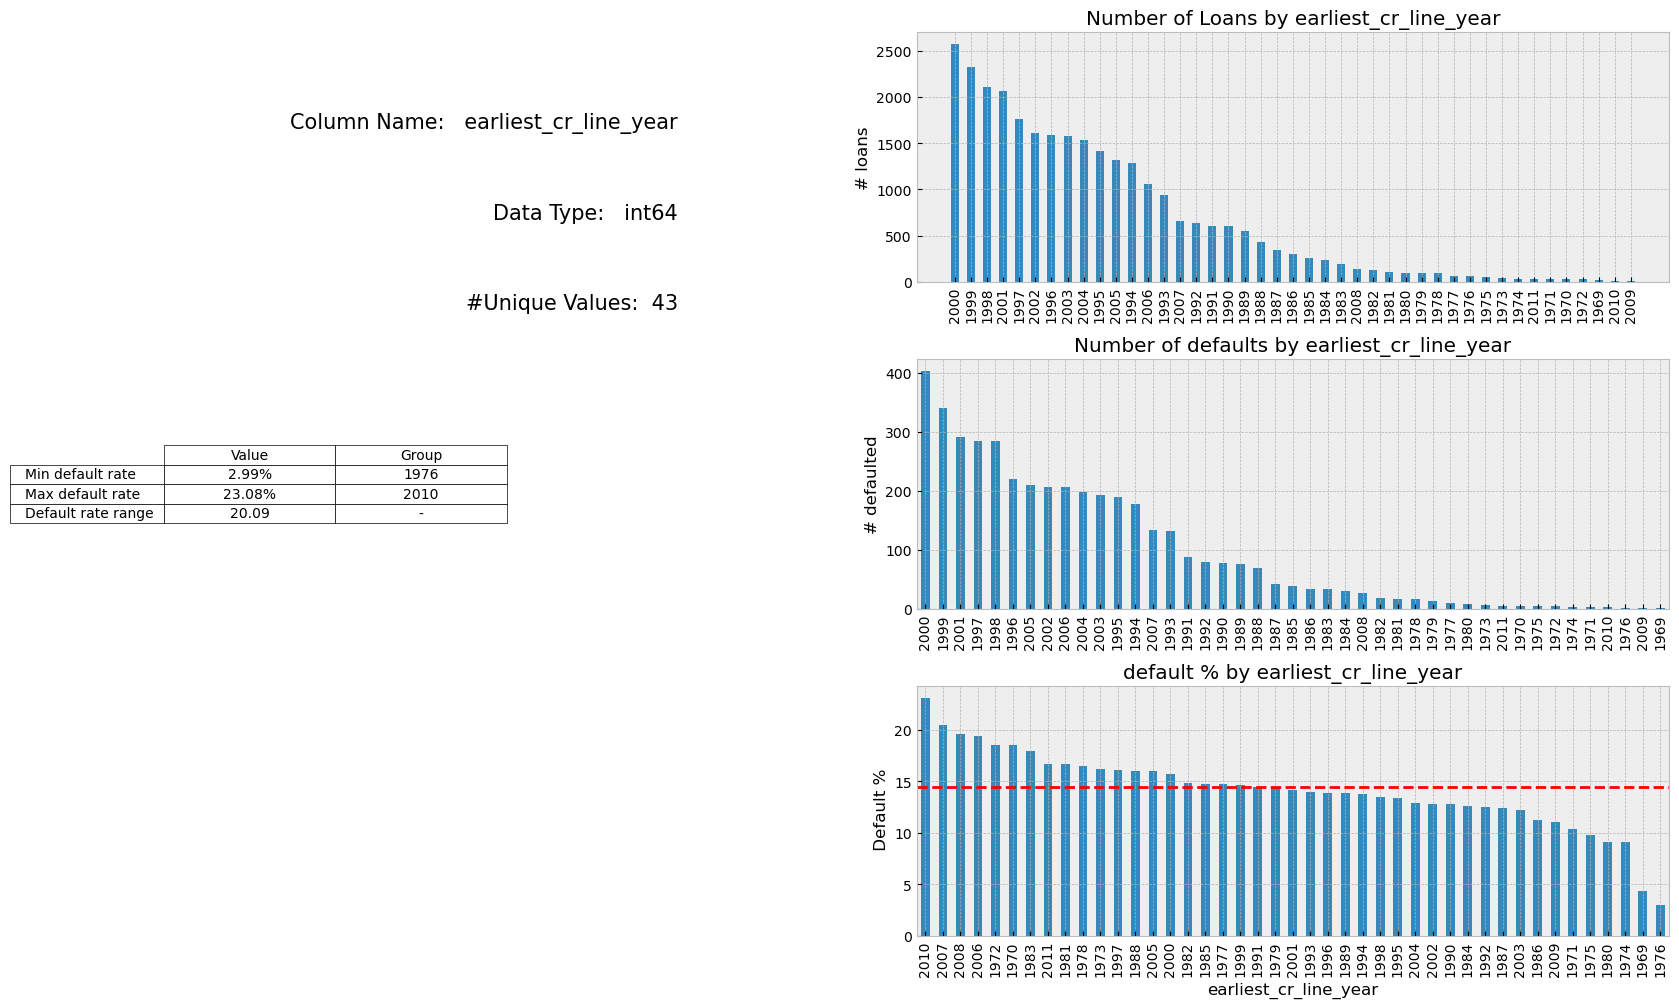

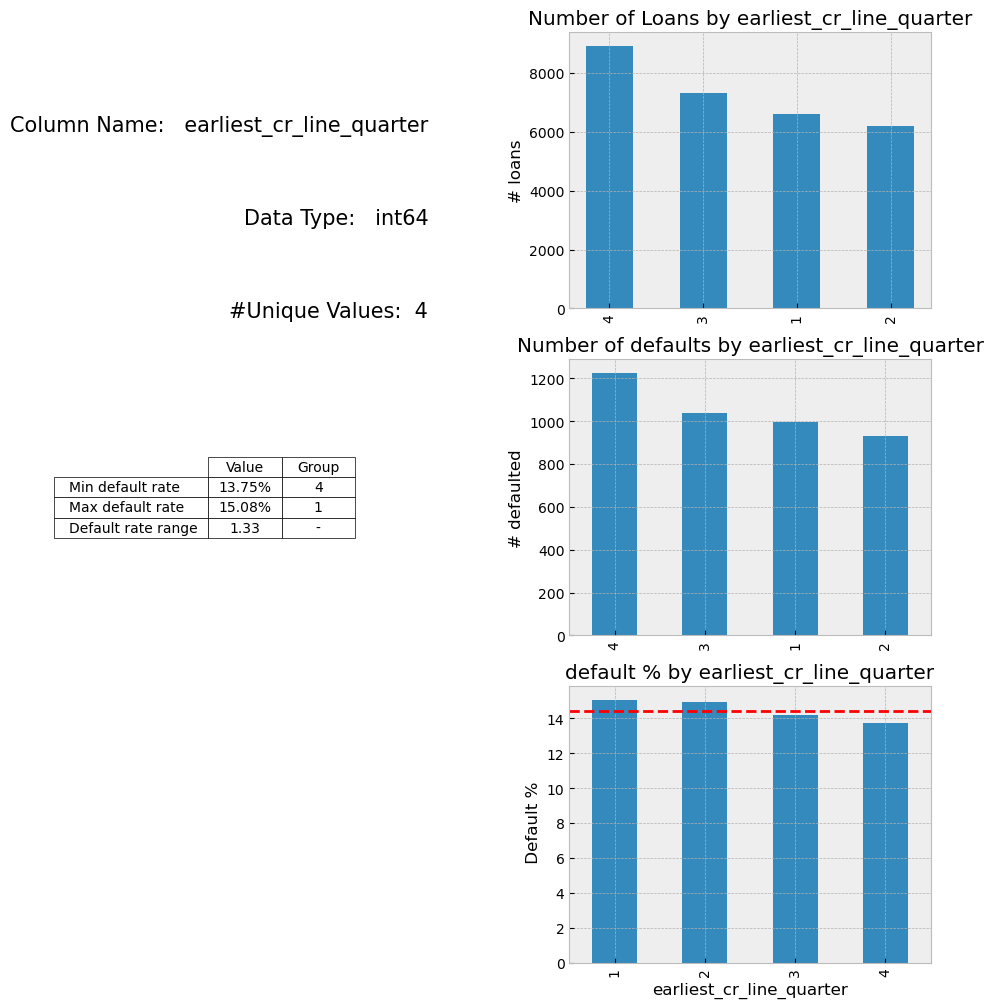

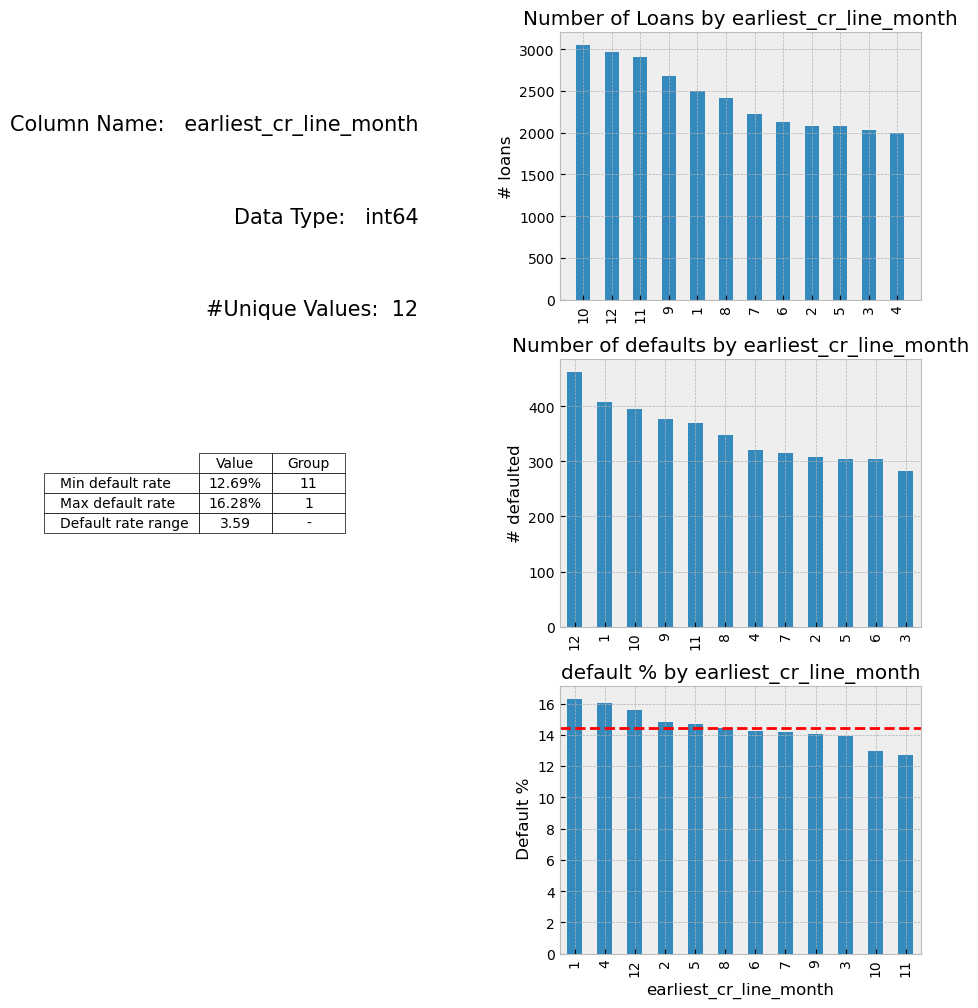

In [36]:
date_list = ['issue_d_year','issue_d_quarter','issue_d_month',
             'last_credit_pull_d_year','last_credit_pull_d_quarter','last_credit_pull_d_month',
             'earliest_cr_line_year','earliest_cr_line_quarter','earliest_cr_line_month']

for col in date_list:
    univariate_segmented_plots(col)

### Use binning to convert some continuous data into categorical  

#### we will exclude rows where the value of column visualised is null
#### We will exclude the max value of 1 for pct funded as we are interested in loans not fully funded

In [27]:
def binned_univariate_segmented_plots(col,df,exclude=''):
    """ Show visualisations for continuous data that has been segmented
        these include
           - bar chart displaying # loans per category
           - bar chart displaying # defaulted loans per category
           - bar chart displaying % defaulted loans per category
           - a series of statistics regarding the highest and lowest % default categories
    """
    df_copy = df.copy()
    inc_lowest = True
    if exclude == 'max':
        df_copy = df_copy[~(df_copy[col] == df_copy[col].max())]
    if exclude == 'min':
        inc_lowest = False
    
    min_value = df_copy[col].min()
    max_value = df_copy[col].max()

    bins = np.linspace(min_value,max_value,10)
    bins

    df['b_'+ col] = pd.cut(df[col], bins=bins, include_lowest=inc_lowest)
    df['b_'+ col]
    univariate_segmented_plots('b_'+ col)



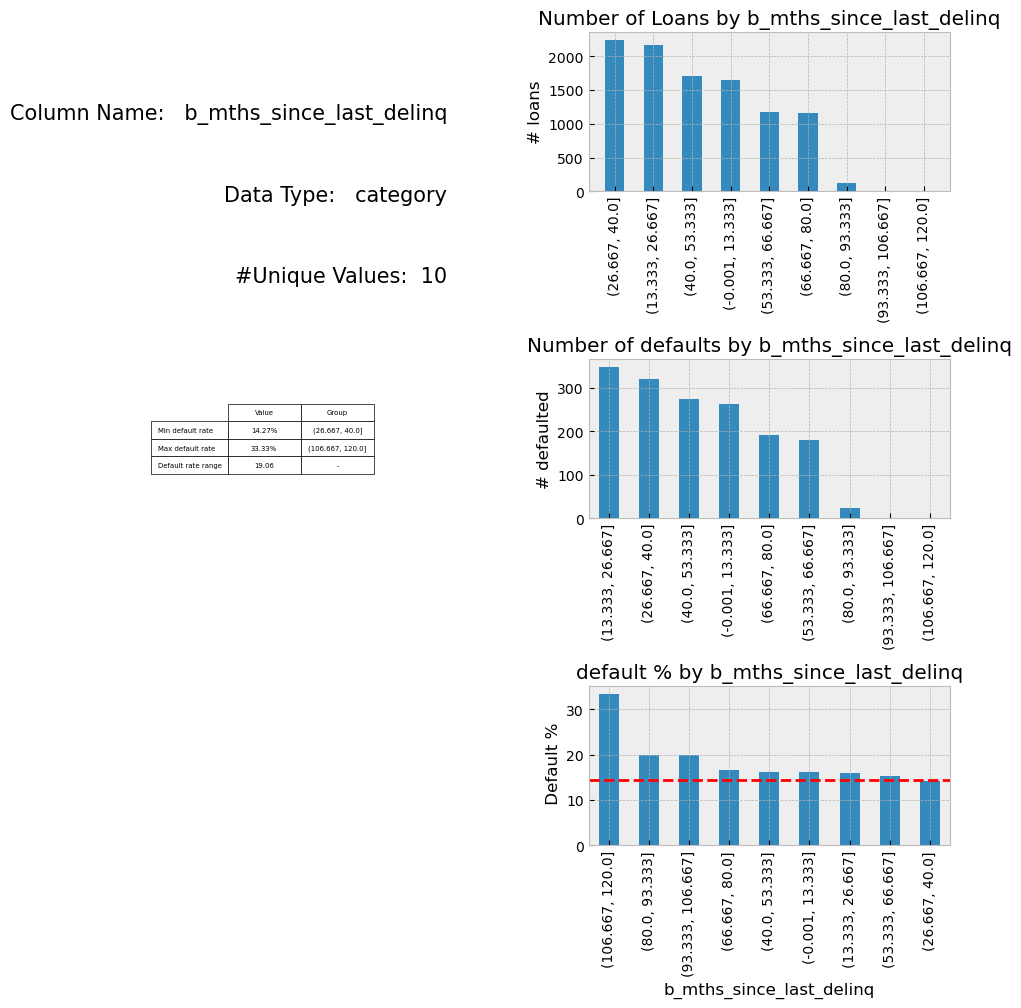

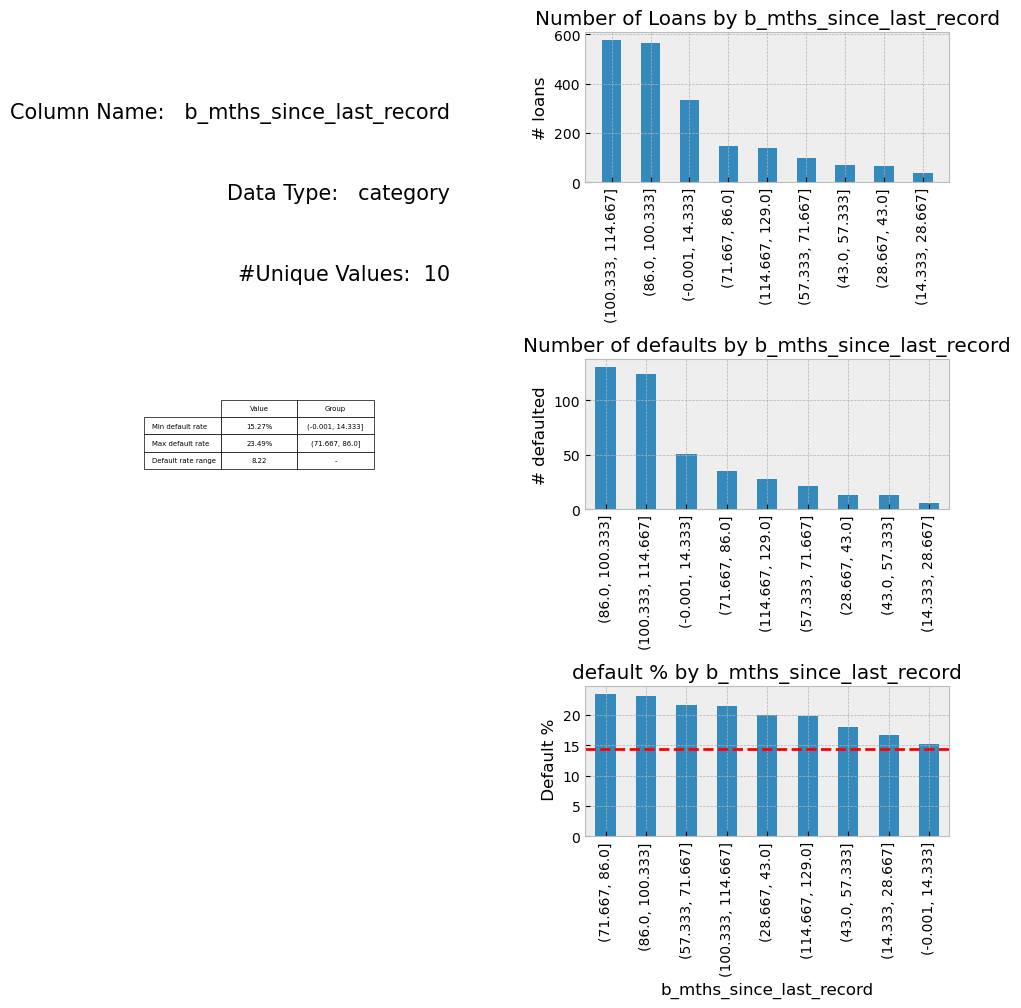

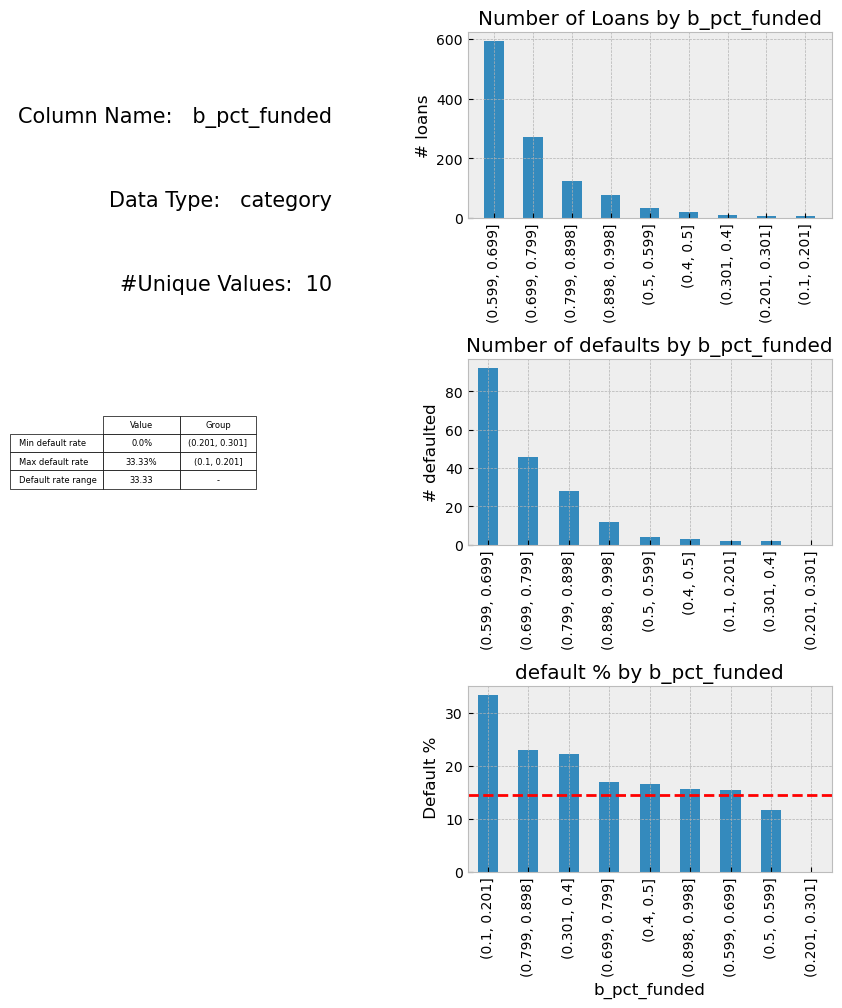

In [37]:
# Analyse the identified fields
binned_list_ex_min = ['mths_since_last_delinq','mths_since_last_record']
binned_list_ex_max = ['pct_funded']

for col in binned_list_ex_min:
    binned_univariate_segmented_plots(col,df)

for col in binned_list_ex_max:
    binned_univariate_segmented_plots(col,df,'max')

### Looking at these results it is observed that
 - mnths since last deliquent has little impact on the default rate
 - the default rate has a positive correlation with months since last record
 - Loans that are not fully funded default more than average

## Bivariate analysis of 2 continuous columns

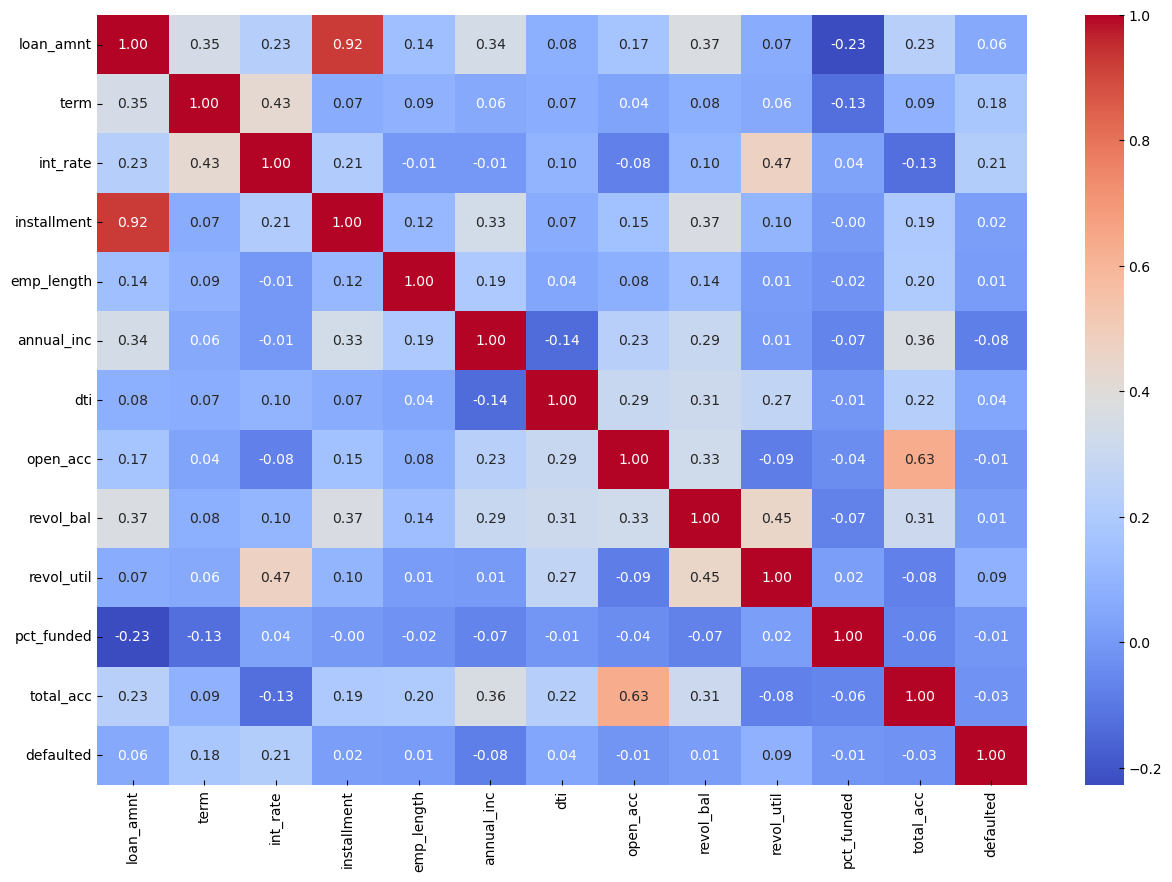

In [29]:
# analyse the 
cont_list=['loan_amnt', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti', 'open_acc', 'revol_bal','revol_util','pct_funded', 'total_acc',
       'defaulted']

def plot_correlations(column_list):
       fig, ax = plt.subplots(figsize=(15,10))    
       sns.heatmap(df[column_list].corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)

plot_correlations(cont_list)

### Any correlations between continuous values and the defaulted value are weak.

#### Only term, int_rate, loan_amnt and revol_util will be looked at further
#### to see if a pattern emerges when split over categories

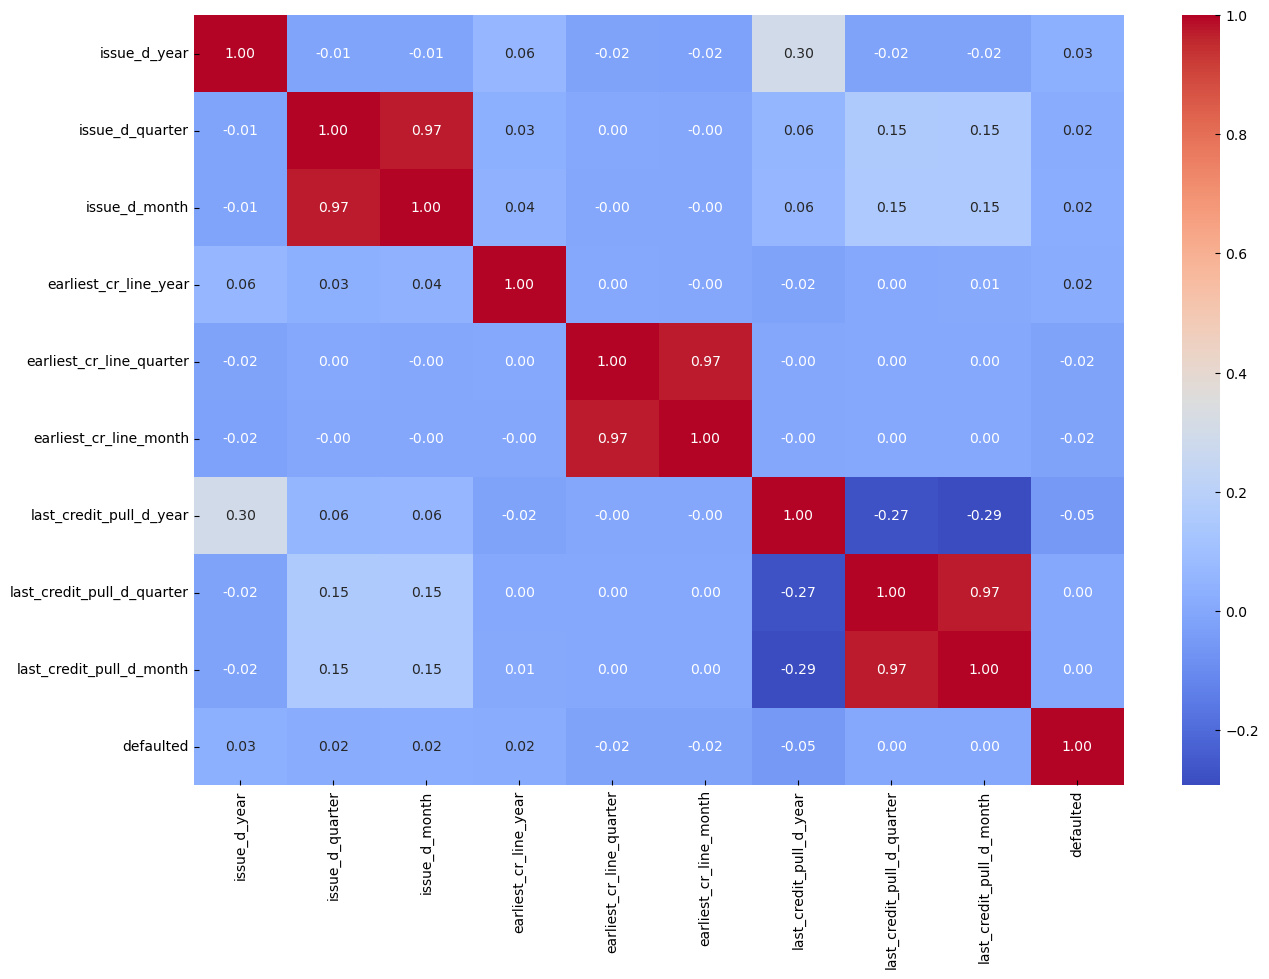

In [30]:
date_list = ['issue_d_year','issue_d_quarter','issue_d_month',
             'earliest_cr_line_year','earliest_cr_line_quarter','earliest_cr_line_month',
             'last_credit_pull_d_year','last_credit_pull_d_quarter','last_credit_pull_d_month',
             'defaulted']

plot_correlations(date_list)

### there are no obvious date fields to explore further
### As we observed a steady increase in default rate by year earlier we will look at issue_d_year further

In [31]:
# based on everything we have seen so far
# lets specify the continuous and categorical columns we are interested in 
cont = ['int_rate','loan_amnt','term','revol_util']
cat = ['home_ownership','purpose','pub_rec','pub_rec_bankruptcies',
       'issue_d_year','region','division','state']



## Bivariate analysis of 1 continuous and 1 categorical column

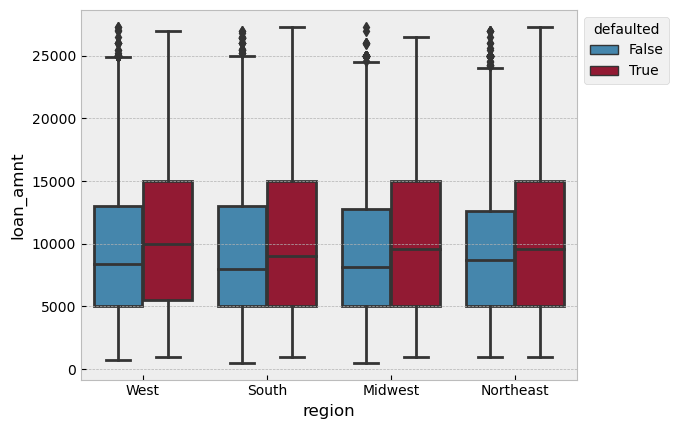

In [32]:
def bivariate_boxplot_cont2cat(col1,col2):
    """ Create a boxplot showing the distribution of
        defaults against a continuous column 
        when sliced by a categorical column
    """
    ax = sns.boxplot(x=col1, y=col2, data=df, hue='defaulted')
    ax.legend(title='defaulted',bbox_to_anchor=(1.2, 1))
    plt.show()

# create a sample plot
bivariate_boxplot_cont2cat('region','loan_amnt')


#### Looking at this analysis it tells us very little about the probability of
#### default and more about the potential impact
#### If I had more time I would bucket the loan amount and compare the
#### default rate of each bucket.

## Bivariate analysis of 2 categorical columns

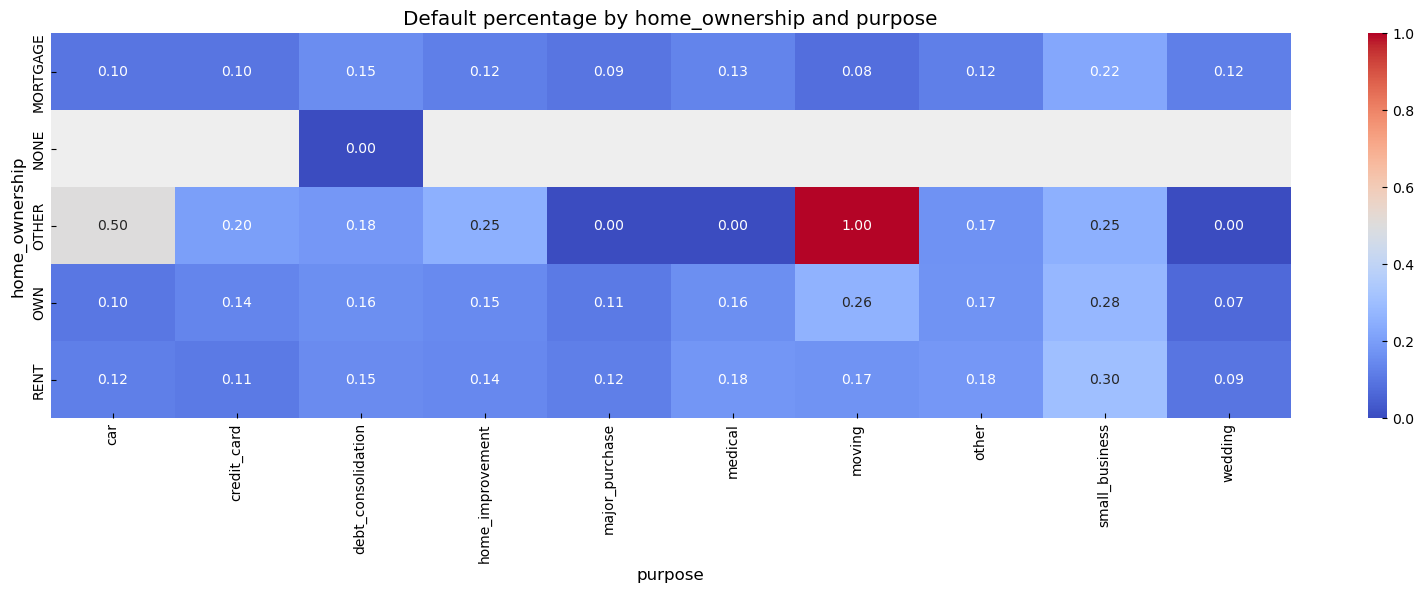

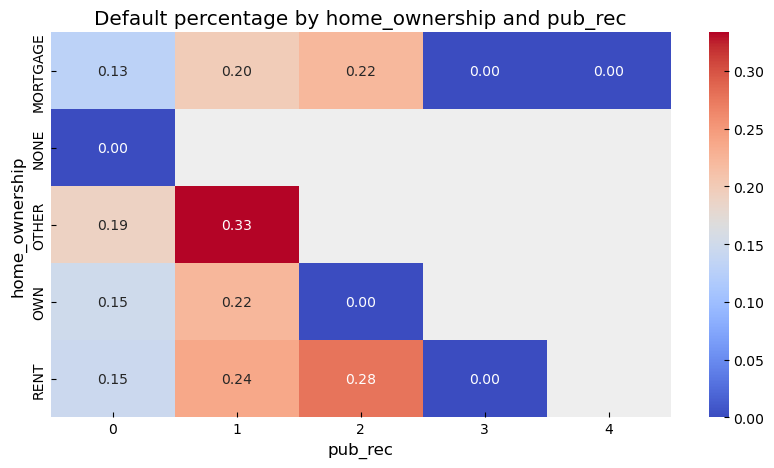

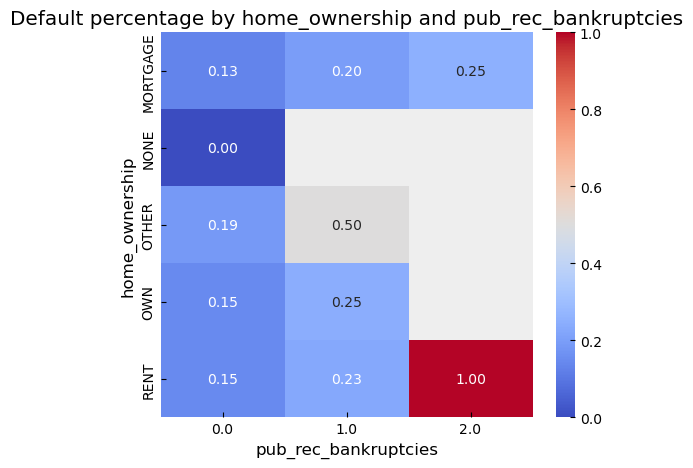

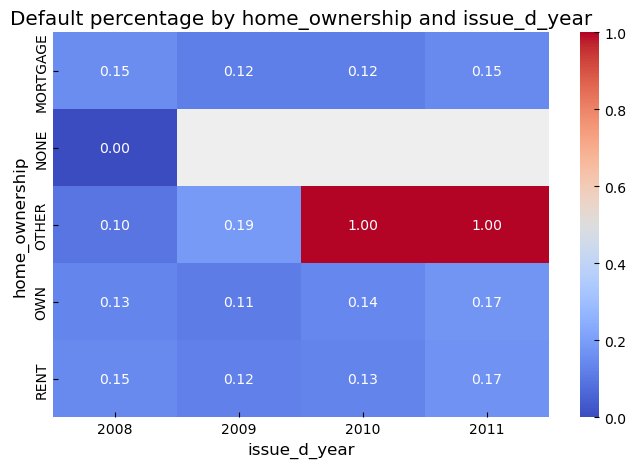

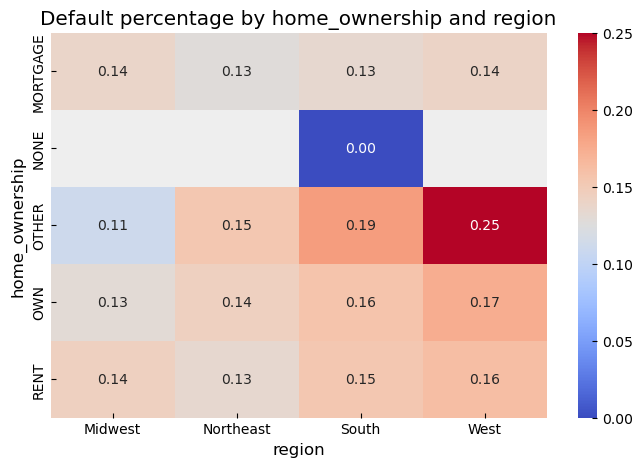

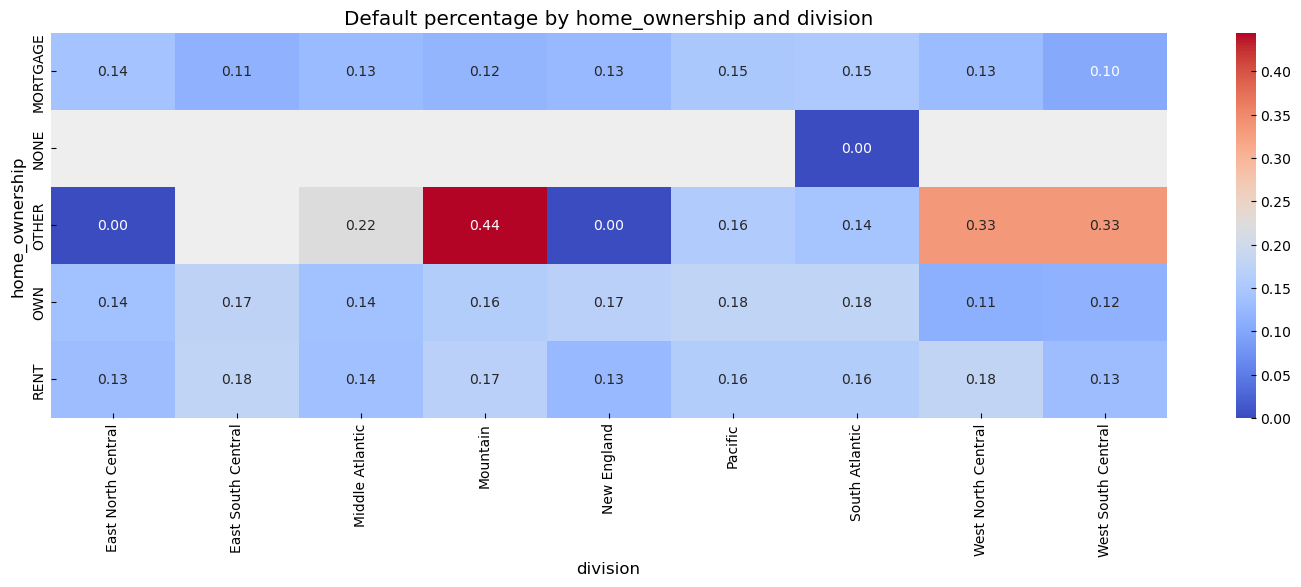

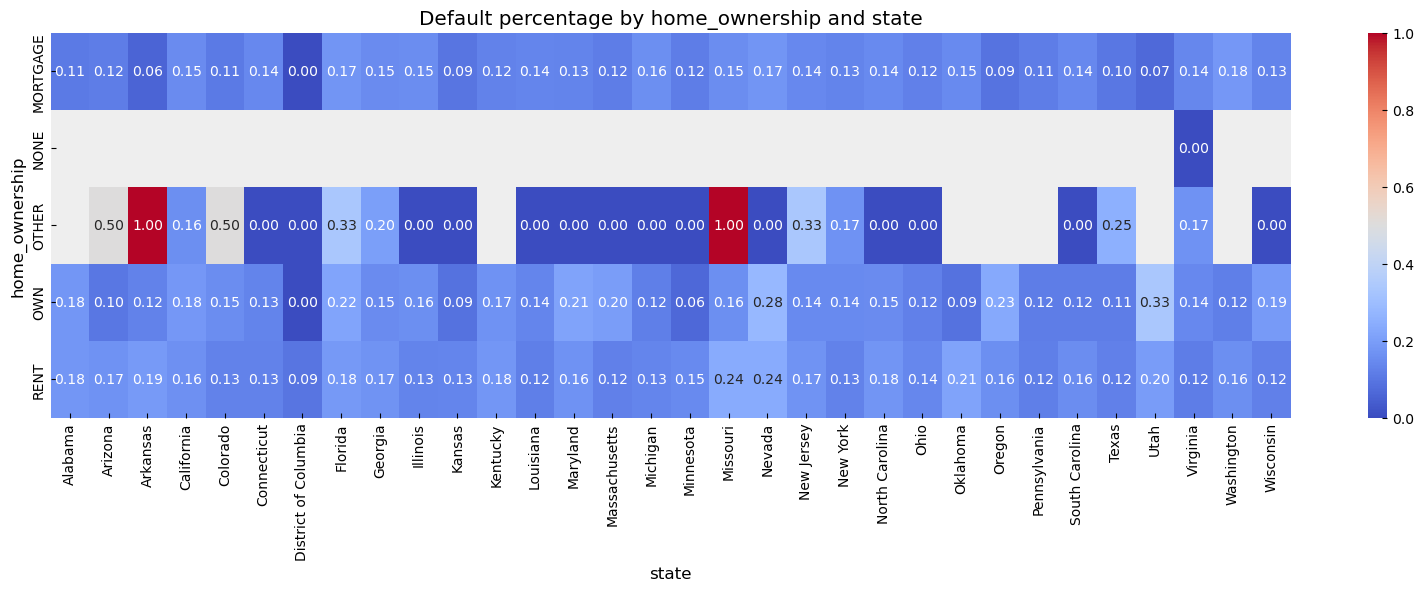

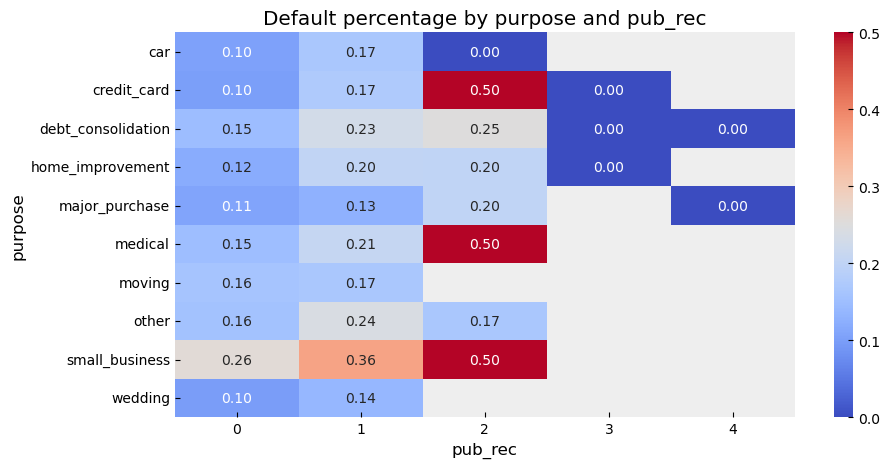

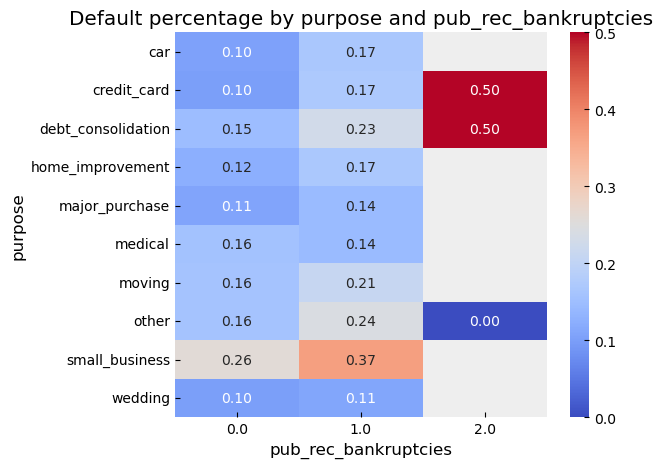

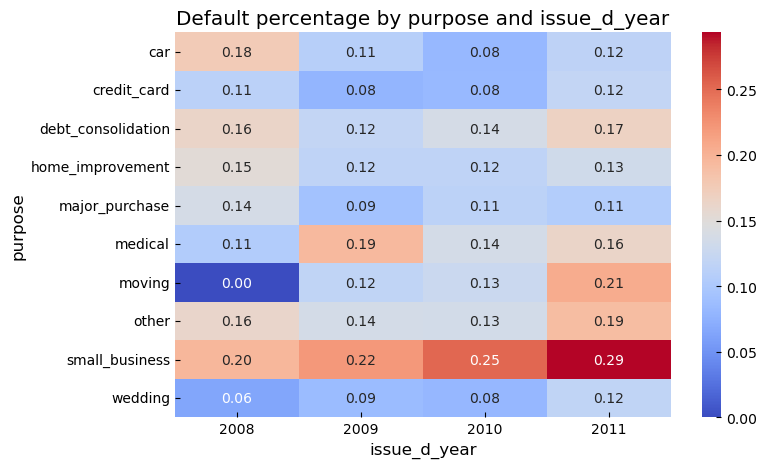

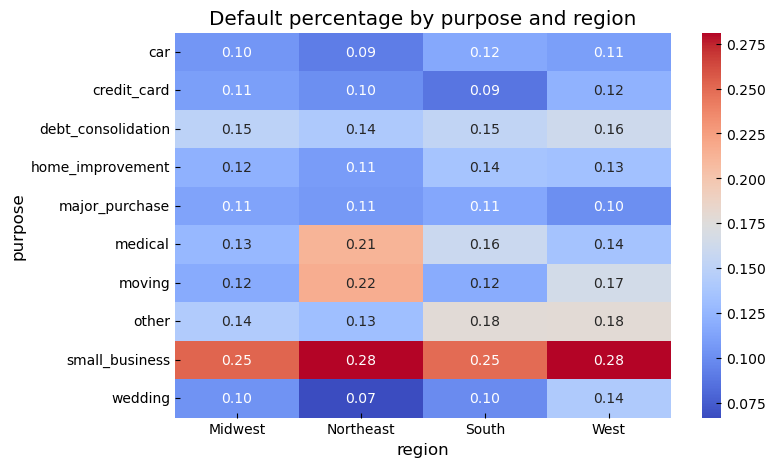

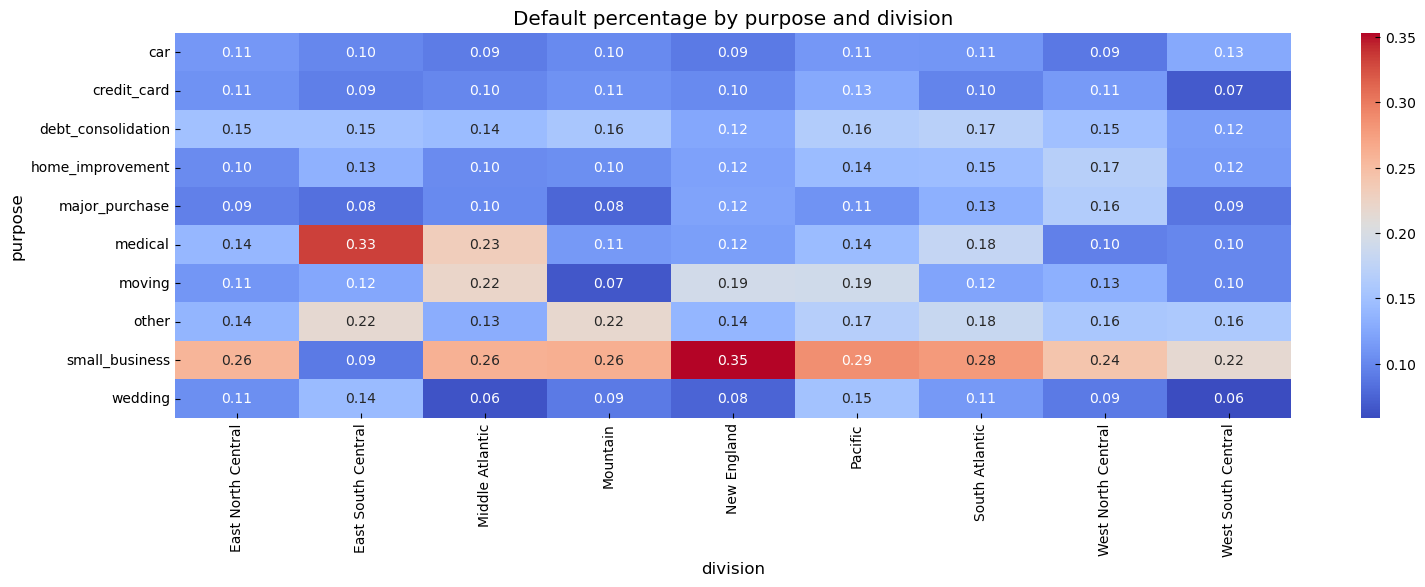

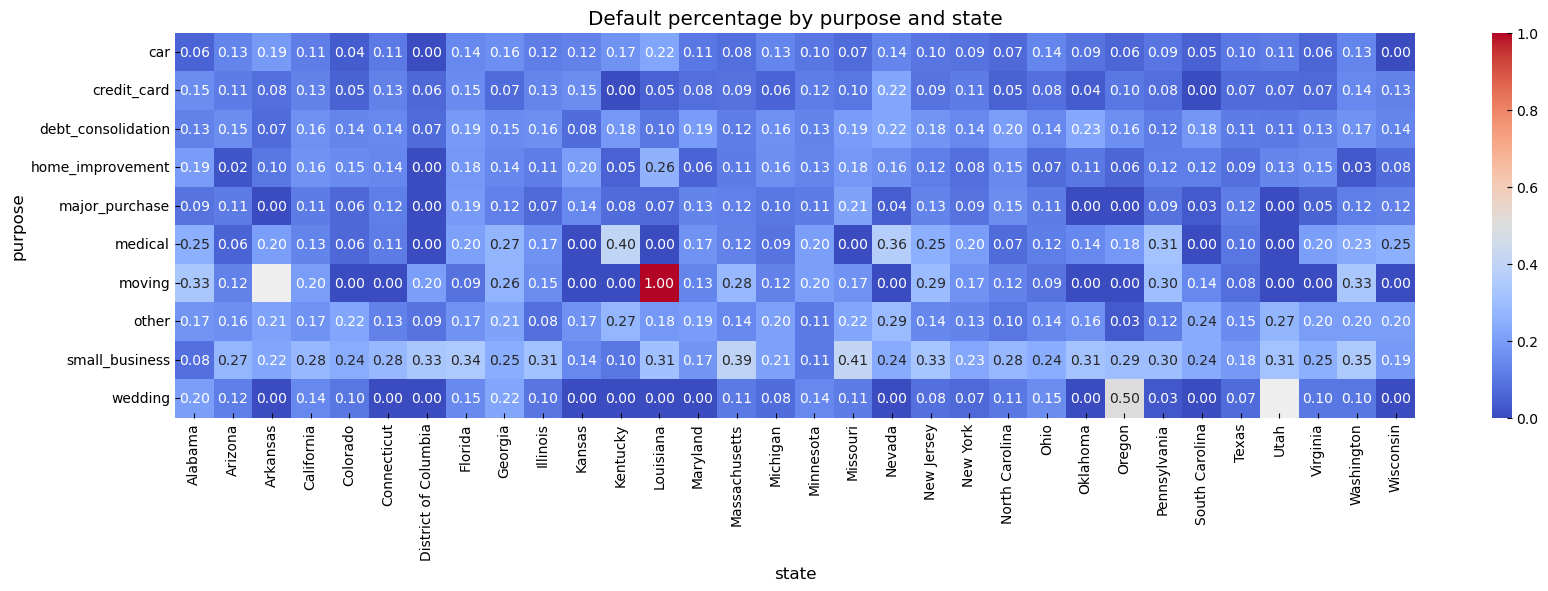

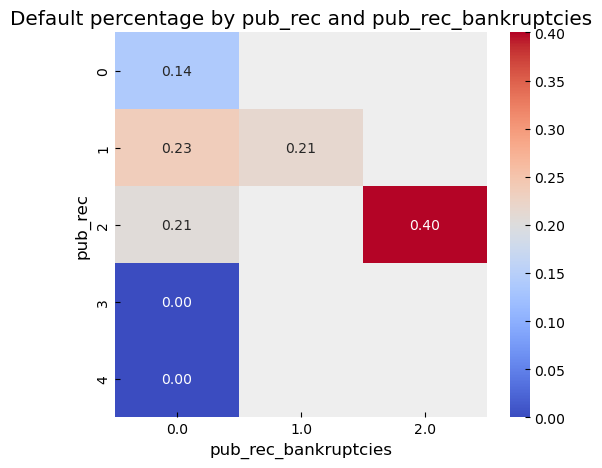

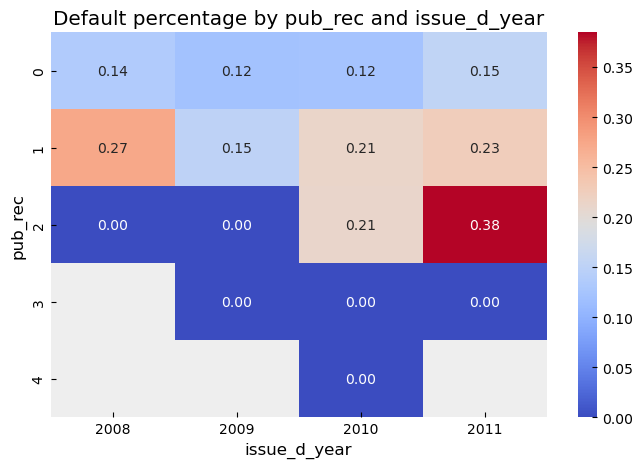

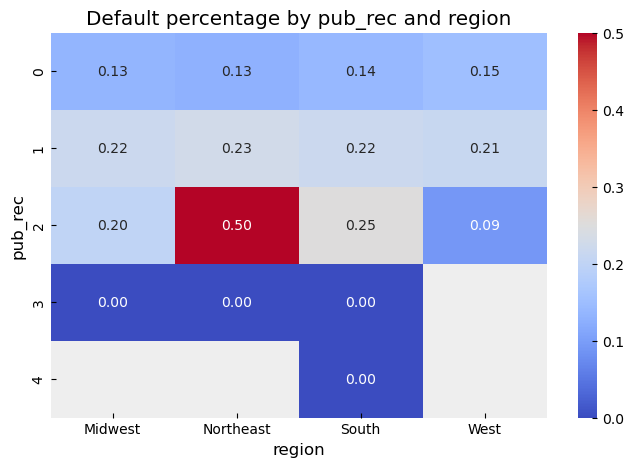

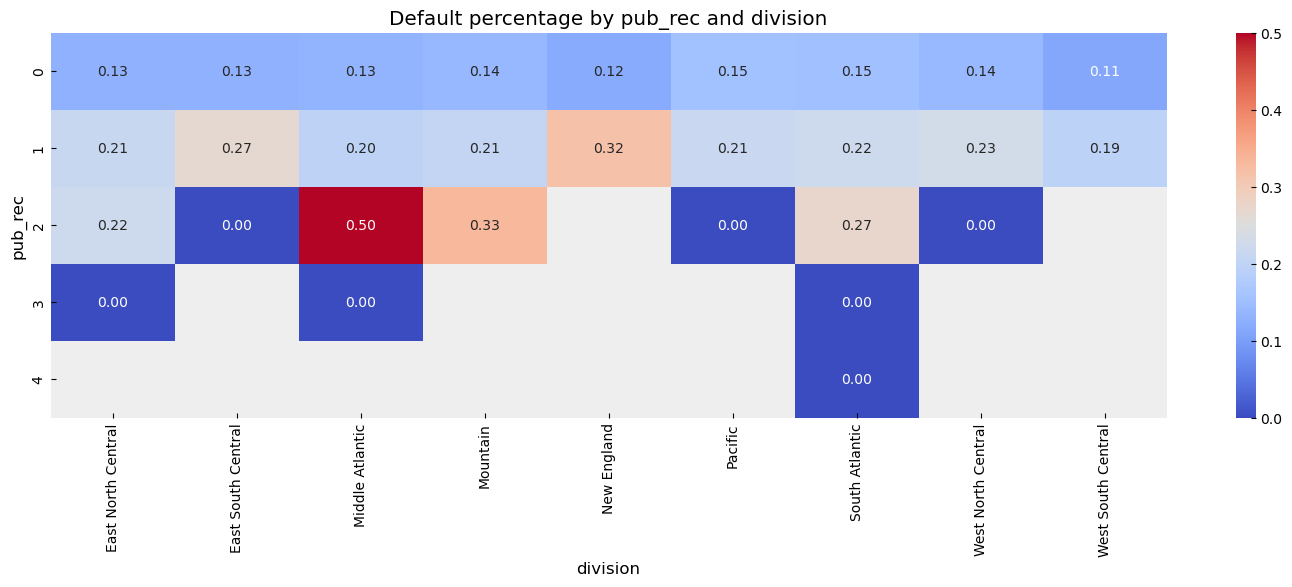

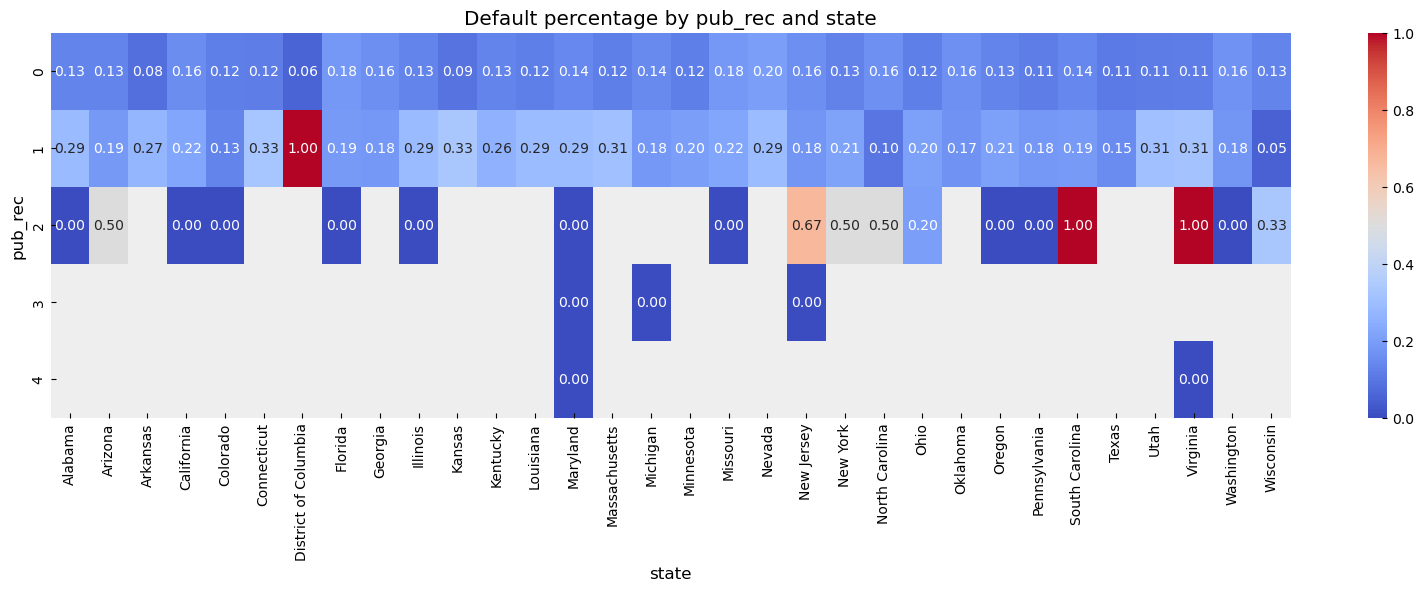

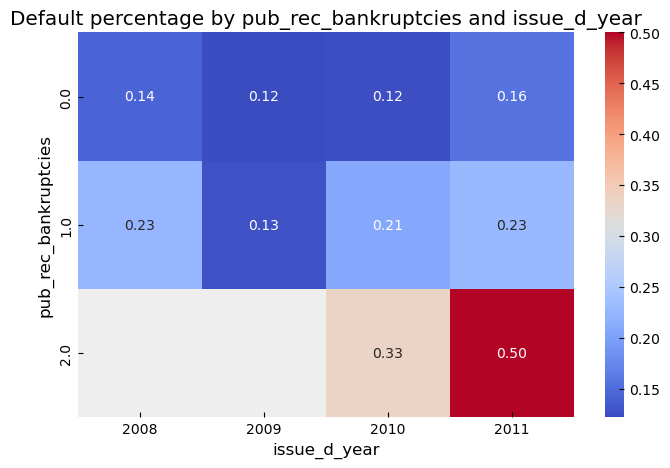

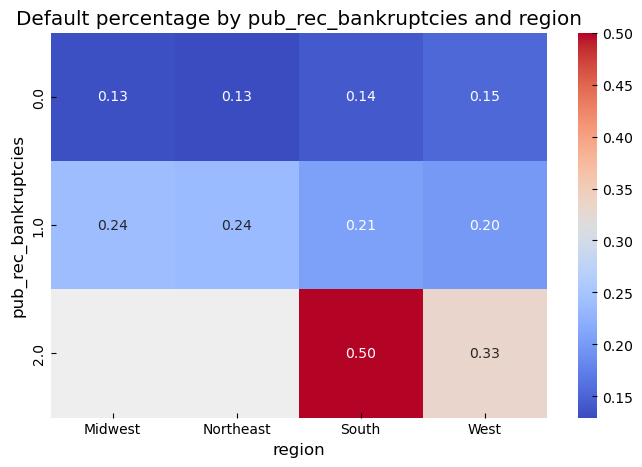

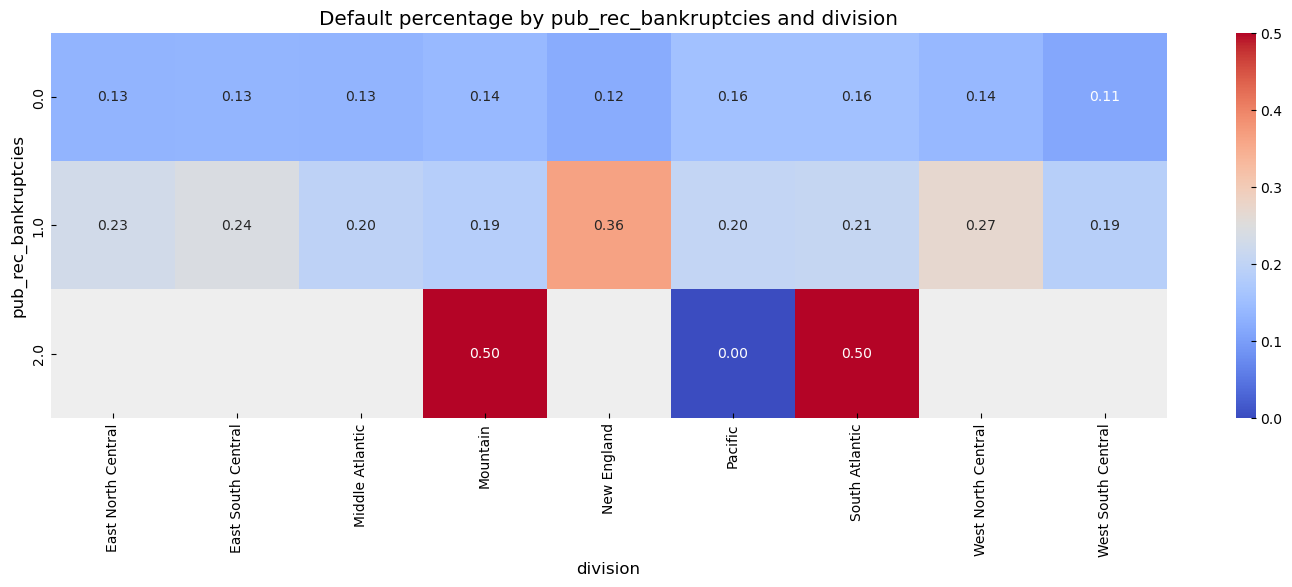

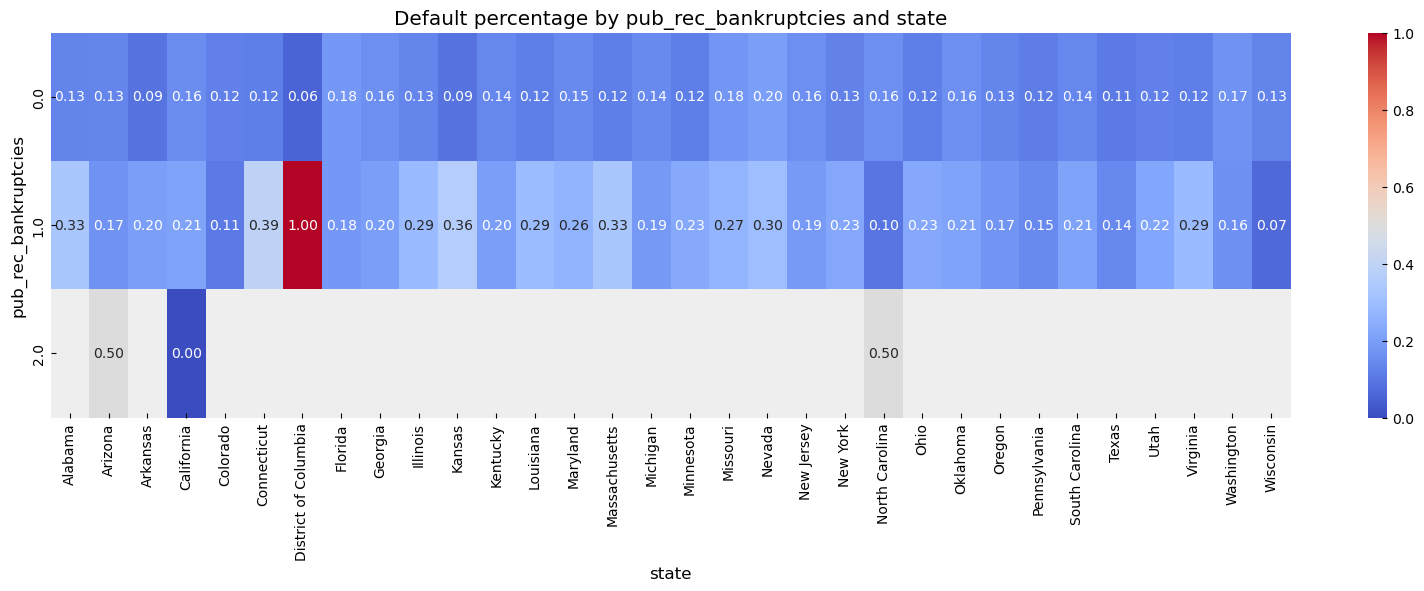

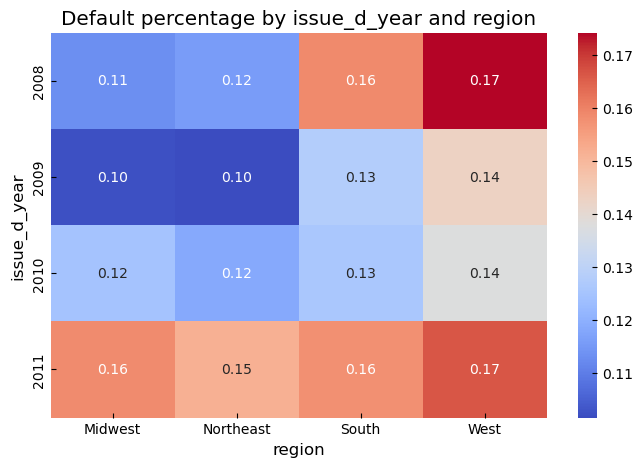

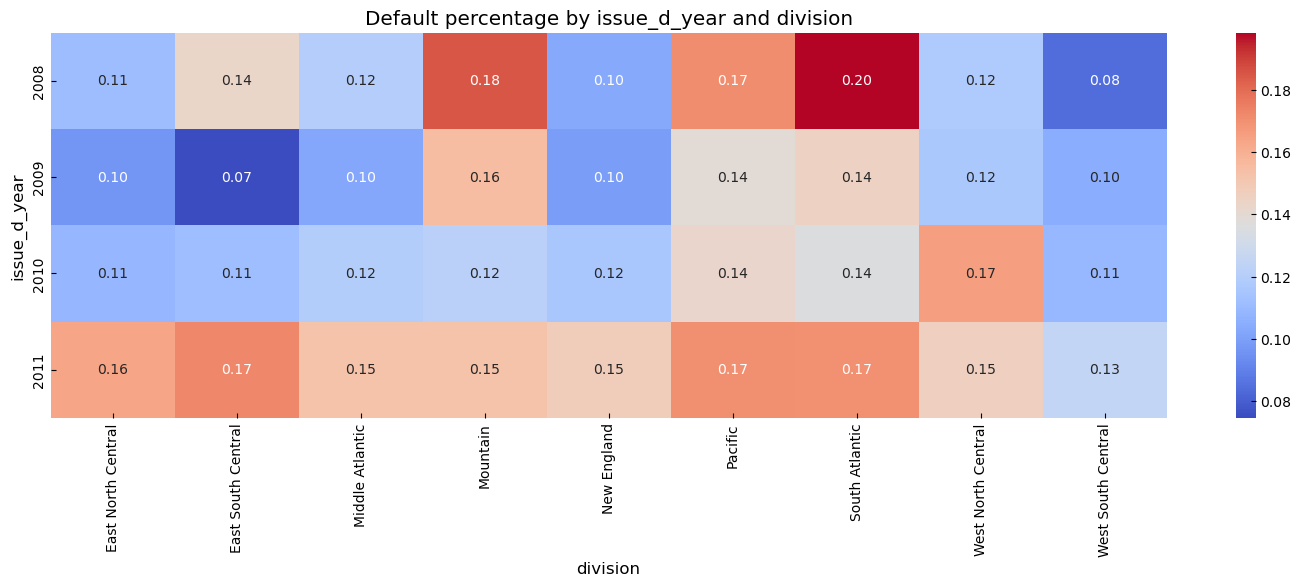

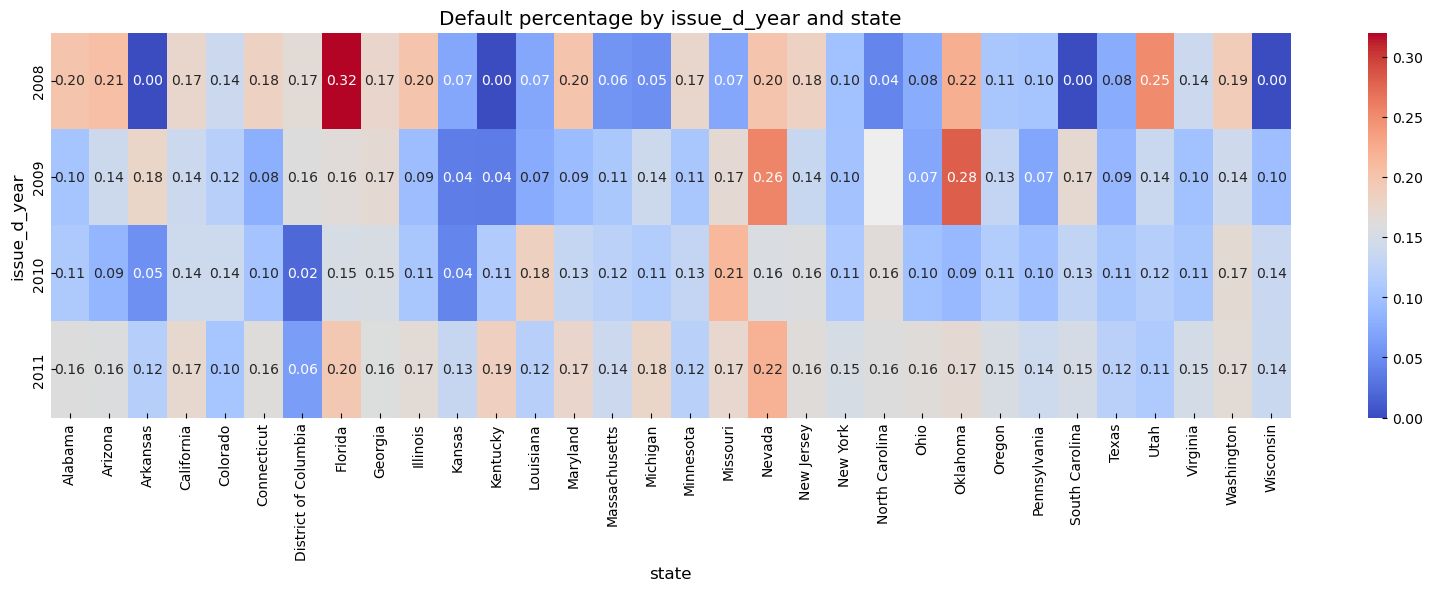

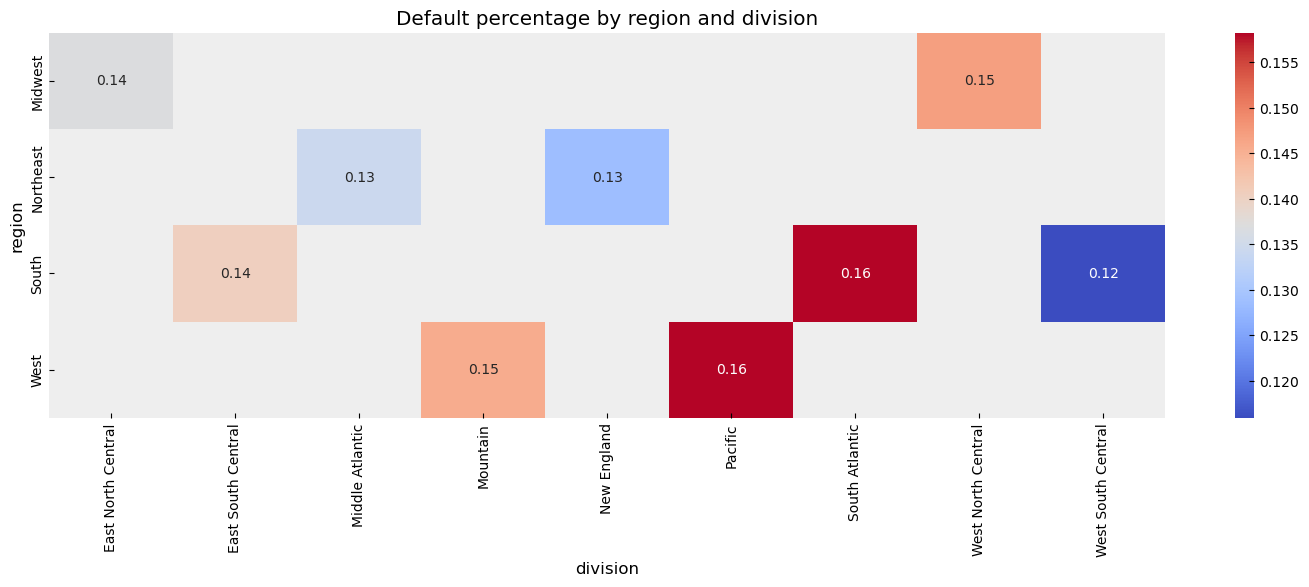

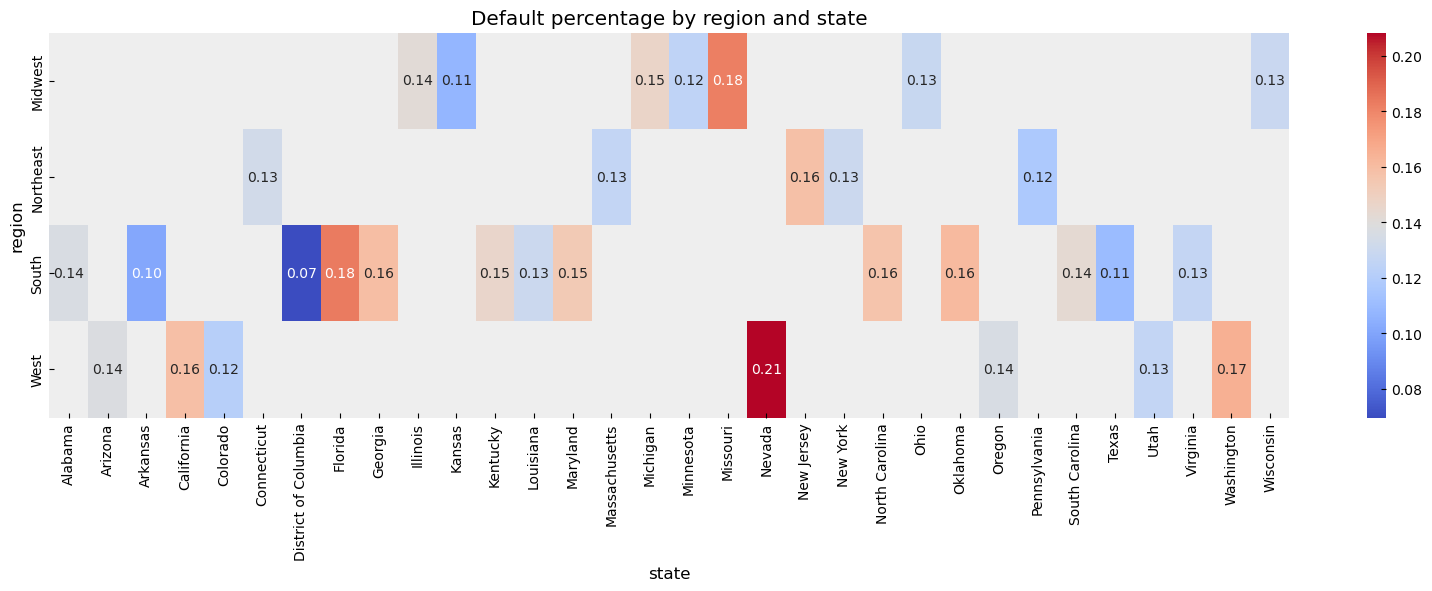

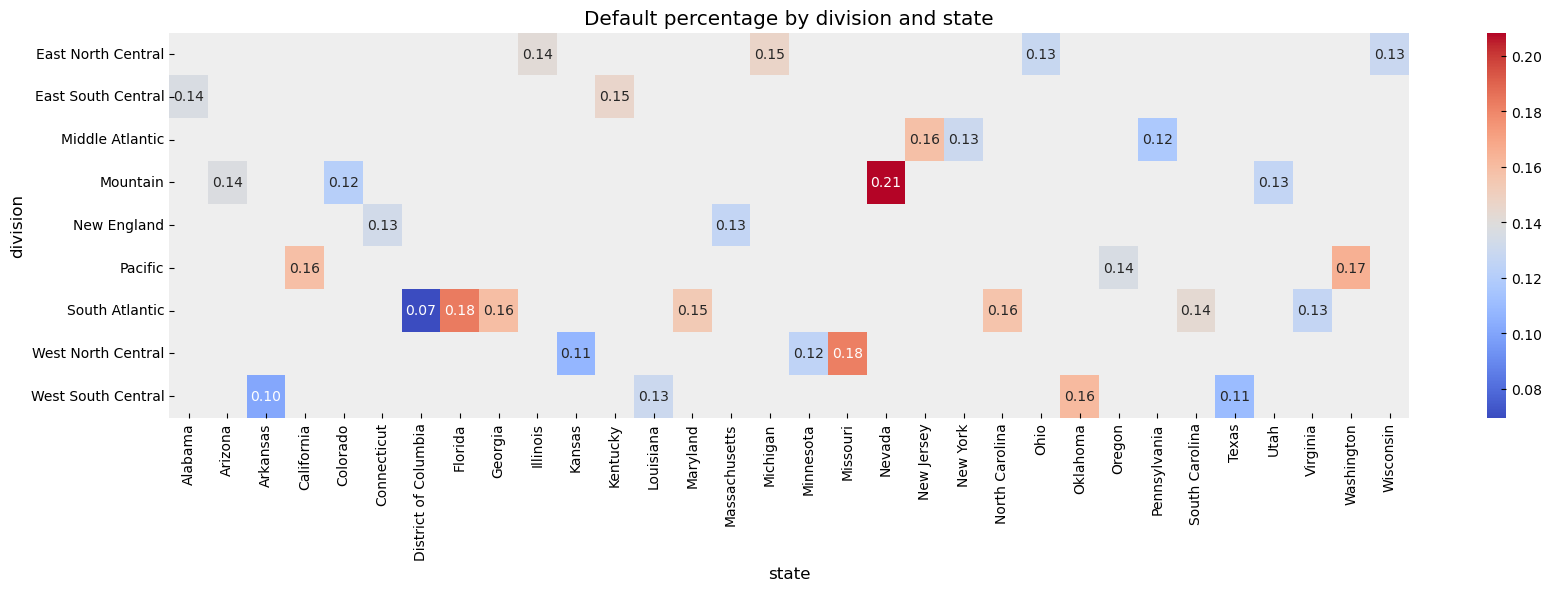

In [33]:
def bivariate_heatmap_cat2cat(col1,col2):
     """ Create a heatmap showing the default rate
          when sliced by 2 categorical columns
     """
     x_size = len(df[col2].unique()) * 2
     if (x_size > 20):
          x_size = 20

     y_size = len(df[col1].unique()) * 0.5
     if (y_size > 20):
          y_size = 20
     if (y_size < 5):
          y_size = 5

     crosstab_df = pd.crosstab(df[col1],df[col2],values=df.defaulted,aggfunc='mean')
     fig, ax = plt.subplots(figsize=(x_size,y_size))    
     sns.heatmap(crosstab_df,annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)
     ax.set_title('Default percentage by ' + col1 + ' and ' + col2)
     plt.show()

# generate the plots for all combinations of identified
# categorical columns
for i in range(len(cat)):
    for j in range(len(cat)):
        if i < j:
            bivariate_heatmap_cat2cat(cat[i],cat[j]) 
    

### This data provided the most insight out of them all.  this included:

- A steady increase in the default rates in the west south central division over the last three years
- Having previous recorded backruptcies is now has a stronger inpact on the risk to default than in did 3 years earlier
- loans for small business are getting riskier in some geographical areas. 

### There is lots of insight to be gained but there is not enough time I could look at this 
### data for a few more weeks and still find new insight.

